In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy as sp
import random

## Preprocessing Data

In [ ]:
audio_folder = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio"
audio_testing_folder = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio_testing"


for root, dirs, files in os.walk(audio_folder):
    for folder in dirs:
        if folder.startswith("VIVOSSPK"):
            folder_path = os.path.join(root, folder)
            wav_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

            # Lấy 5 files cuối của mỗi folder làm test
            sorted_wav_files = sorted(wav_files)[-5:]

            # Di chuyển 5 files cuối qua 'audio_testing' folder
            for wav_file in sorted_wav_files:
                src_path = os.path.join(folder_path, wav_file)
                dst_path = os.path.join(audio_testing_folder, wav_file)
                shutil.move(src_path, dst_path)
                print(f"Moved {wav_file} to audio_testing folder.")


In [16]:
DATASET_ROOT = os.path.join("/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos")
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# 90% for training, 10% for validation
VALID_SPLIT = 0.1

# Setup thông số cho training model
SHUFFLE_SEED = 11
SAMPLING_RATE = 16000
SCALE = 0.5
BATCH_SIZE = 128
EPOCHS = 100

In [21]:
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # Nếu là `audio` hoặc `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

Checking số lượng sample trong data

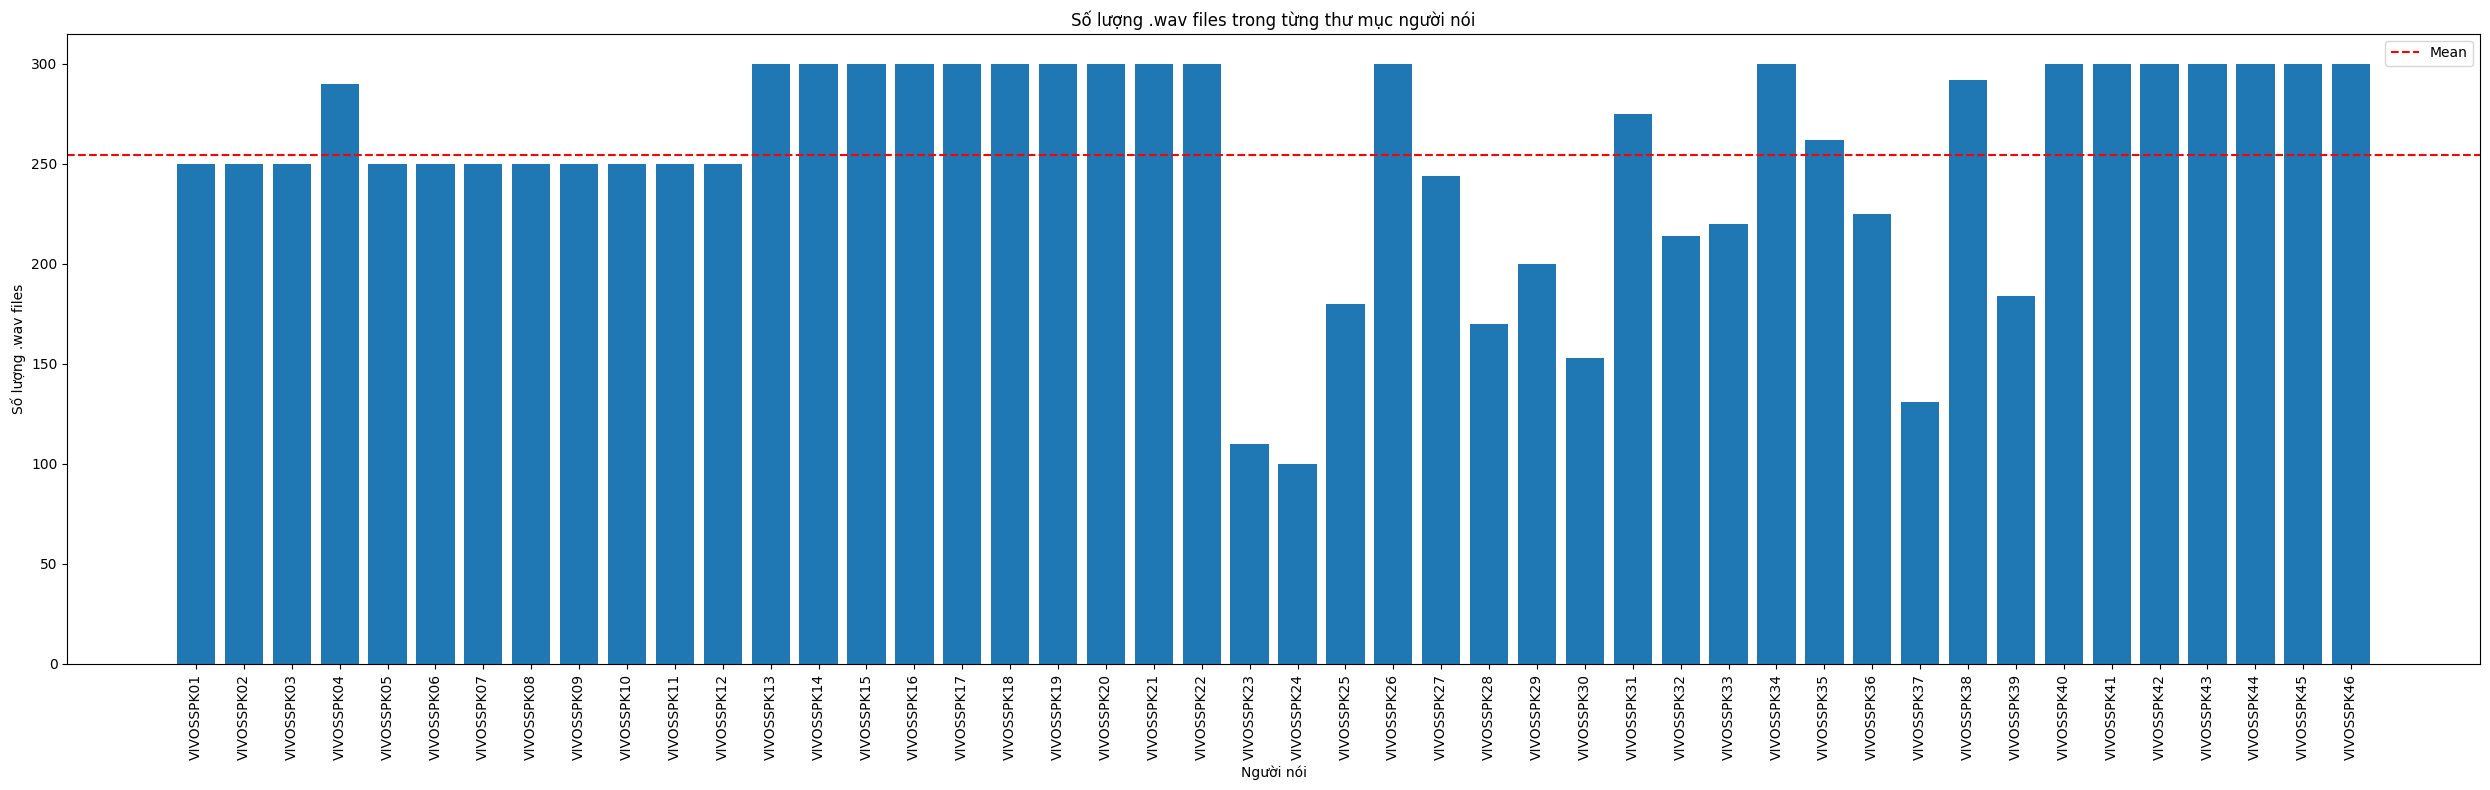

In [23]:
# Khởi tạo một dictionary để chứa thông tin
subfolder_counts = {}

for root, _, files in os.walk(DATASET_AUDIO_PATH):
    wav_files = [file for file in files if file.endswith(".wav")]
    if wav_files:
        subfolder_name = os.path.basename(root)
        subfolder_counts[subfolder_name] = len(wav_files)

subfolder_names = list(subfolder_counts.keys())
file_counts = list(subfolder_counts.values())

# Tính giá trị trung bình số lượng files trong từng folder
mean_file_count = sum(file_counts) / len(file_counts)

# Sắp xếp theo tên tệp
sorted_data = sorted(zip(subfolder_names, file_counts), key=lambda x: x[0])
subfolder_names, file_counts = zip(*sorted_data)

# Plot data
plt.figure(figsize=(25, 8))
plt.bar(subfolder_names, file_counts)
plt.axhline(
    mean_file_count, color="red", linestyle="--", label="Mean"
)
plt.xlabel("Người nói")
plt.ylabel("Số lượng .wav files")
plt.xticks(rotation=90)
plt.title("Số lượng .wav files trong từng thư mục người nói")
plt.legend()
plt.tight_layout()

plt.show()


In [24]:
# Xử lý thư mục nhiễu
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Thấy {} files thuộc {} thư mục".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)


Thấy 6 files thuộc 2 thư mục


In [25]:
# Chia tập dữ liệu nhiễu thành các đoạn nhỏ, mỗi đoạn có 16.000 sampling_rate
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

def load_noise_sample(path):
    """
    Chia mẫu nhiễu từ tệp WAV.

    Args:
        path (str): Đường dẫn đến tệp WAV.

    Returns:
        tf.Tensor hoặc None: Tensor mẫu nhiễu hoặc None nếu tỷ lệ mẫu không chính xác.
    """
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate cho {} không chính xác".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} file nhiễu được chia thành {} mẫu với mỗi mẫu dài khoảng {} sec".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 file nhiễu được chia thành 354 mẫu với mỗi mẫu dài khoảng 1 sec


## Feature Extract

In [27]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """
    Tạo một bộ dữ liệu âm thanh và nhãn.
    """
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """
    Đọc và giải mã tệp âm thanh.
    """
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        """
        Tạo một tensor ngẫu nhiên có cùng kích thước với âm thanh
        trong khoảng từ 0 đến số lượng mẫu nhiễu
        """
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Tính tỷ lệ biên độ giữa âm thanh và nhiễu
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Thêm nhiễu được thay đổi tỷ lệ vào âm thanh
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    """
    # Vì tf.signal.fft áp dụng FFT trên kích thước bên trong nhất (innermost dimension),
    cần nén các kích thước và sau đó mở rộng chúng lại sau FFT
    """
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)
    # Trả về giá trị tuyệt đối của một nửa đầu của FFT đại diện cho các tần số dương
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Lấy danh sách đường dẫn tệp âm thanh cùng với nhãn tương ứng
class_names = os.listdir(DATASET_AUDIO_PATH)
class_names.sort()
print("Class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Đang xử lý người nói {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Có {} files thuộc vào {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Chia data về tập train và validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Có {} files dùng cho training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Có {} files dùng cho validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(BATCH_SIZE)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Thêm nhiễu vào tập training
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Chuyển đổi waveform sang miền tần số bằng hàm `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Class names: ['VIVOSSPK01', 'VIVOSSPK02', 'VIVOSSPK03', 'VIVOSSPK04', 'VIVOSSPK05', 'VIVOSSPK06', 'VIVOSSPK07', 'VIVOSSPK08', 'VIVOSSPK09', 'VIVOSSPK10', 'VIVOSSPK11', 'VIVOSSPK12', 'VIVOSSPK13', 'VIVOSSPK14', 'VIVOSSPK15', 'VIVOSSPK16', 'VIVOSSPK17', 'VIVOSSPK18', 'VIVOSSPK19', 'VIVOSSPK20', 'VIVOSSPK21', 'VIVOSSPK22', 'VIVOSSPK23', 'VIVOSSPK24', 'VIVOSSPK25', 'VIVOSSPK26', 'VIVOSSPK27', 'VIVOSSPK28', 'VIVOSSPK29', 'VIVOSSPK30', 'VIVOSSPK31', 'VIVOSSPK32', 'VIVOSSPK33', 'VIVOSSPK34', 'VIVOSSPK35', 'VIVOSSPK36', 'VIVOSSPK37', 'VIVOSSPK38', 'VIVOSSPK39', 'VIVOSSPK40', 'VIVOSSPK41', 'VIVOSSPK42', 'VIVOSSPK43', 'VIVOSSPK44', 'VIVOSSPK45', 'VIVOSSPK46']
Đang xử lý người nói VIVOSSPK01
Đang xử lý người nói VIVOSSPK02
Đang xử lý người nói VIVOSSPK03
Đang xử lý người nói VIVOSSPK04
Đang xử lý người nói VIVOSSPK05
Đang xử lý người nói VIVOSSPK06
Đang xử lý người nói VIVOSSPK07
Đang xử lý người nói VIVOSSPK08
Đang xử lý người nói VIVOSSPK09
Đang xử lý người nói VIVOSSPK10
Đang xử lý người nói V

In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


# Model V1

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 16)             784       ['activation[0][0]']          
                                                                                              

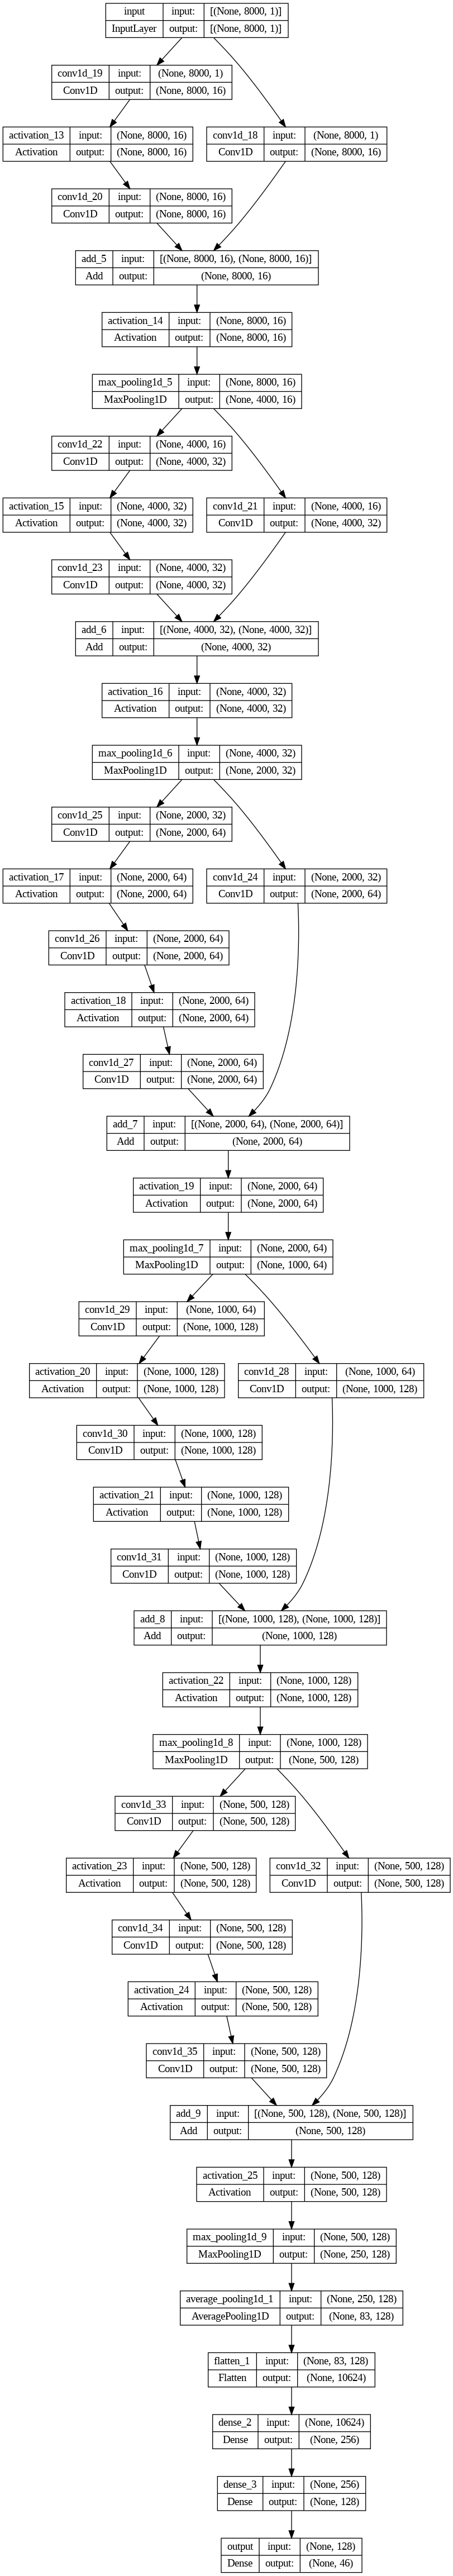

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file="/content/drive/MyDrive/Master/VoiceProcessing/cnn_model.png", show_shapes=True)

In [ ]:
!pip install livelossplot

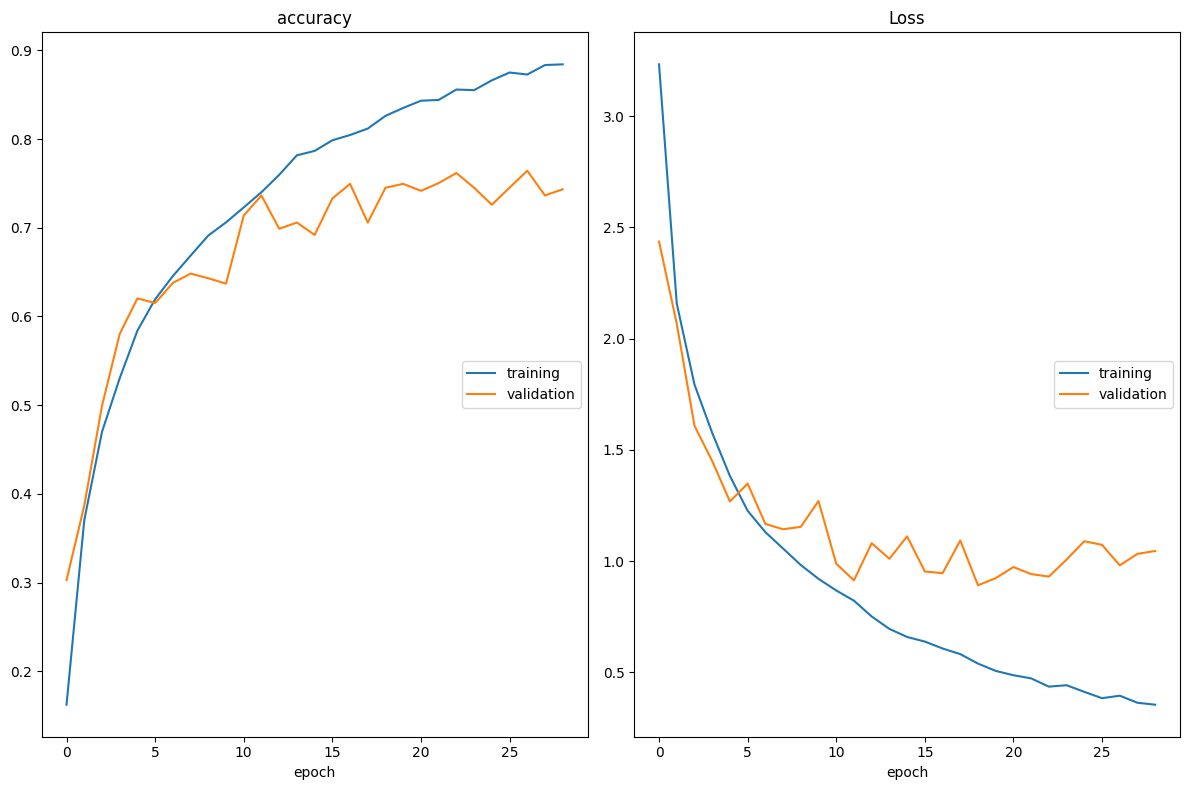

accuracy
	training         	 (min:    0.162, max:    0.884, cur:    0.884)
	validation       	 (min:    0.303, max:    0.764, cur:    0.743)
Loss
	training         	 (min:    0.354, max:    3.233, cur:    0.354)
	validation       	 (min:    0.891, max:    2.436, cur:    1.045)
81/81 [==============================] - 17s 191ms/step - loss: 0.3542 - accuracy: 0.8843 - val_loss: 1.0453 - val_accuracy: 0.7435
CPU times: user 40min 39s, sys: 1min 27s, total: 42min 6s
Wall time: 15min 9s


In [ ]:
%%time

from livelossplot import PlotLossesKeras

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, PlotLossesKeras()],
)

In [ ]:
print(model.evaluate(valid_ds))

36/36 [==============================] - 2s 36ms/step - loss: 0.8910 - accuracy: 0.7452
[0.8910201191902161, 0.7452006936073303]


In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 0s 7ms/step
Speaker: VIVOSSPK18	Predicted: VIVOSSPK18


Speaker: VIVOSSPK01	Predicted: VIVOSSPK17


Speaker: VIVOSSPK36	Predicted: VIVOSSPK32


Speaker: VIVOSSPK45	Predicted: VIVOSSPK42


Speaker: VIVOSSPK45	Predicted: VIVOSSPK42


Speaker: VIVOSSPK04	Predicted: VIVOSSPK04


Speaker: VIVOSSPK40	Predicted: VIVOSSPK40


Speaker: VIVOSSPK09	Predicted: VIVOSSPK09


Speaker: VIVOSSPK28	Predicted: VIVOSSPK28


Speaker: VIVOSSPK06	Predicted: VIVOSSPK06


## Model V2


In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
# Define the learning rate you want to use
custom_learning_rate = 0.0001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)

model.compile(
    optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_model_v5.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             96        ['input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['dropout[0][0]']             
                                                                                              

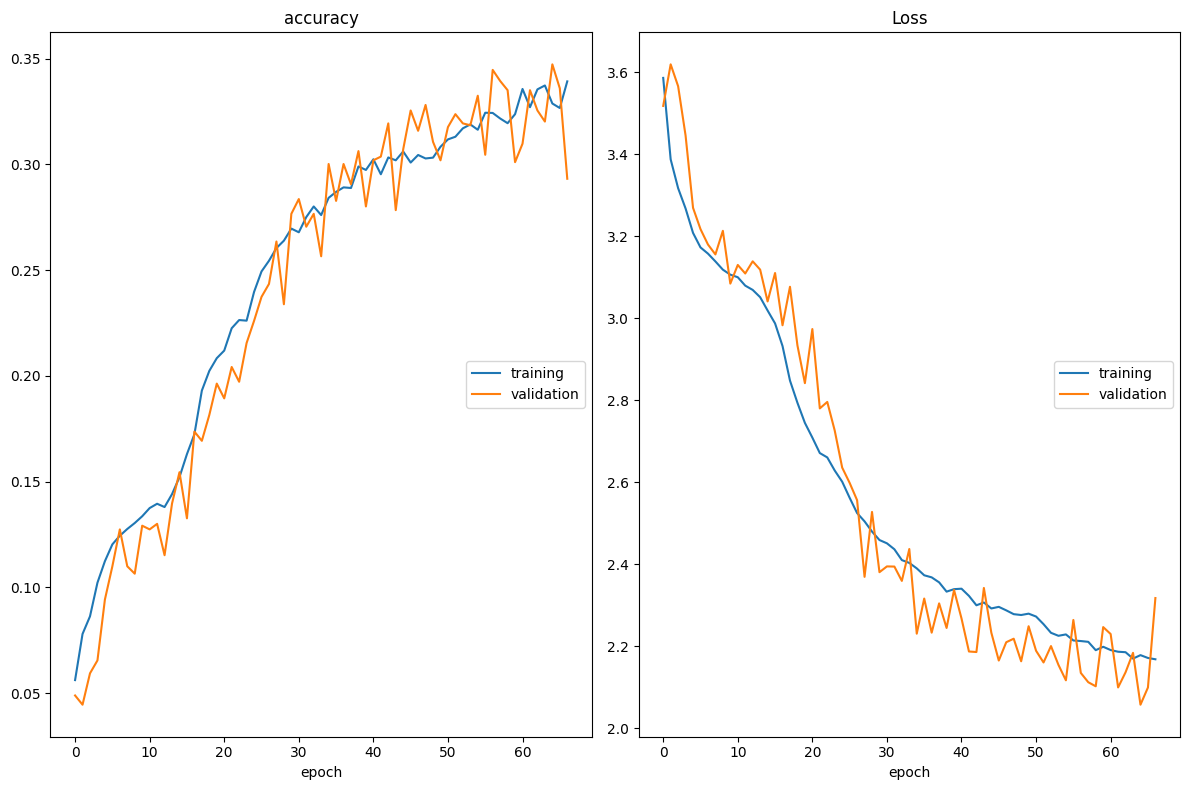

accuracy
	training         	 (min:    0.056, max:    0.339, cur:    0.339)
	validation       	 (min:    0.045, max:    0.347, cur:    0.293)
Loss
	training         	 (min:    2.168, max:    3.587, cur:    2.168)
	validation       	 (min:    2.058, max:    3.620, cur:    2.318)
323/323 [==============================] - 62s 191ms/step - loss: 2.1685 - accuracy: 0.3392 - val_loss: 2.3178 - val_accuracy: 0.2932
Epoch 68/100
282/323 [=========================>....] - ETA: 7s - loss: 2.1571 - accuracy: 0.3367

KeyboardInterrupt: ignored

In [ ]:
%%time

from livelossplot import PlotLossesKeras
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, PlotLossesKeras()],
)

## Model V3

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
# Define the learning rate you want to use
custom_learning_rate = 0.0001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)

model.compile(
    optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_model_v4.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 8000, 16)             0         ['conv1d_1[0][0]']            
                                                                                                  
 activation (Activation)     (None, 8000, 16)             0         ['dropout[0][0]']             
                                                                                              

In [ ]:
!pip install livelossplot

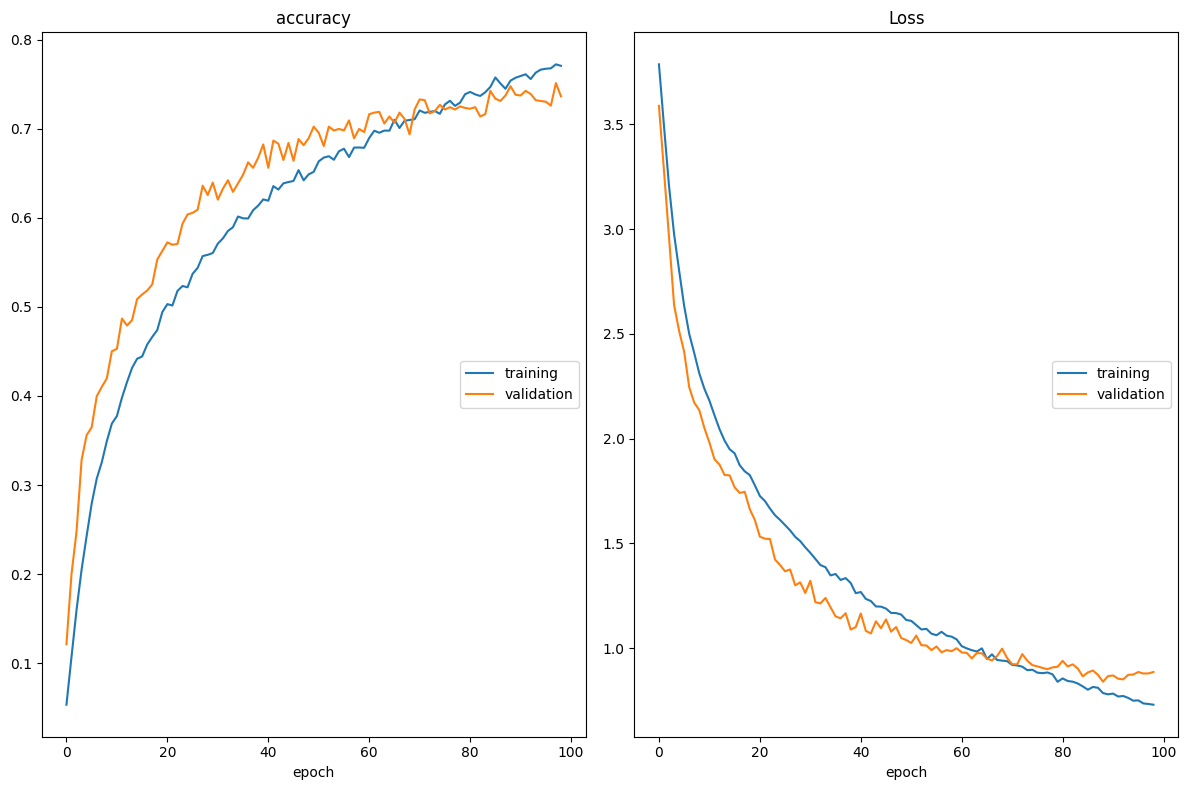

accuracy
	training         	 (min:    0.053, max:    0.772, cur:    0.771)
	validation       	 (min:    0.121, max:    0.751, cur:    0.736)
Loss
	training         	 (min:    0.730, max:    3.787, cur:    0.730)
	validation       	 (min:    0.839, max:    3.589, cur:    0.886)
81/81 [==============================] - 12s 134ms/step - loss: 0.7298 - accuracy: 0.7707 - val_loss: 0.8860 - val_accuracy: 0.7365
CPU times: user 2h 17min 5s, sys: 3min 51s, total: 2h 20min 57s
Wall time: 32min 33s


In [ ]:
%%time

from livelossplot import PlotLossesKeras
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, PlotLossesKeras()],
)

In [ ]:
print(model.evaluate(valid_ds))

36/36 [==============================] - 1s 25ms/step - loss: 0.8394 - accuracy: 0.7478
[0.8394326567649841, 0.7478184700012207]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import soundfile as sf
model = load_model("/content/drive/MyDrive/Master/VoiceProcessing/cnn_model_v5.h5")

In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)

    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]
    print(y_pred)
    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        print(class_names[labels[index]])
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 0s 5ms/step
[17 17 16 22 20 28 33 14 32 40]
Speaker: VIVOSSPK37	Predicted: VIVOSSPK18
VIVOSSPK37


Speaker: VIVOSSPK18	Predicted: VIVOSSPK18
VIVOSSPK18


Speaker: VIVOSSPK20	Predicted: VIVOSSPK20
VIVOSSPK20


Speaker: VIVOSSPK21	Predicted: VIVOSSPK21
VIVOSSPK21


Speaker: VIVOSSPK17	Predicted: VIVOSSPK17
VIVOSSPK17


Speaker: VIVOSSPK32	Predicted: VIVOSSPK32
VIVOSSPK32


Speaker: VIVOSSPK34	Predicted: VIVOSSPK34
VIVOSSPK34


Speaker: VIVOSSPK14	Predicted: VIVOSSPK14
VIVOSSPK14


Speaker: VIVOSSPK28	Predicted: VIVOSSPK29
VIVOSSPK28


Speaker: VIVOSSPK42	Predicted: VIVOSSPK42
VIVOSSPK42


In [ ]:
# Define a function to load and preprocess a new audio file
# Define a function to load and preprocess a new audio file
def preprocess_new_audio(audio_file_path, input_shape):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(audio_file_path), 1, 16000)

    # Extract the audio data as a NumPy array
    audio_data = audio.numpy()

    # Ensure the audio data has the expected shape or pad it if needed
    if audio_data.shape[0] < input_shape[0]:
        # Pad with zeros at the end
        pad_length = input_shape[0] - audio_data.shape[0]
        audio_data = np.pad(audio_data, ((0, pad_length), (0, 0)), mode='constant')
    elif audio_data.shape[0] > input_shape[0]:
        # Trim the audio if it's longer
        audio_data = audio_data[:input_shape[0], :]

    # Add a batch dimension
    audio_data = audio_data.reshape((1, *input_shape))

    return audio_data

SAMPLING_RATE = 16000
# Path to the new audio file you want to predict
new_audio_file_path = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/audio_testing/VIVOSSPK18_297.wav"

# Define the expected input shape for the model
input_shape = (SAMPLING_RATE // 2, 1)

# Preprocess the new audio
new_audio = preprocess_new_audio(new_audio_file_path, input_shape)

# Predict the class of the new audio
predicted_probabilities = model.predict(new_audio)
predicted_class_index = np.argmax(predicted_probabilities, axis=-1)
predicted_class_index = int(predicted_class_index)
# Map the predicted class index to a class name using your class_names list or dictionary
#class_names = ["Class1", "Class2", "Class3", ...]  # Replace with your class names
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class_name)

1/1 [==============================] - 0s 25ms/step
Predicted Class: VIVOSSPK13


In [ ]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Model V4

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
# Define the learning rate you want to use
custom_learning_rate = 0.0001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=custom_learning_rate)

model.compile(
    optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_model_v5.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_37 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 dropout_20 (Dropout)        (None, 8000, 16)             0         ['conv1d_37[0][0]']           
                                                                                                  
 activation_26 (Activation)  (None, 8000, 16)             0         ['dropout_20[0][0]']          
                                                                                            

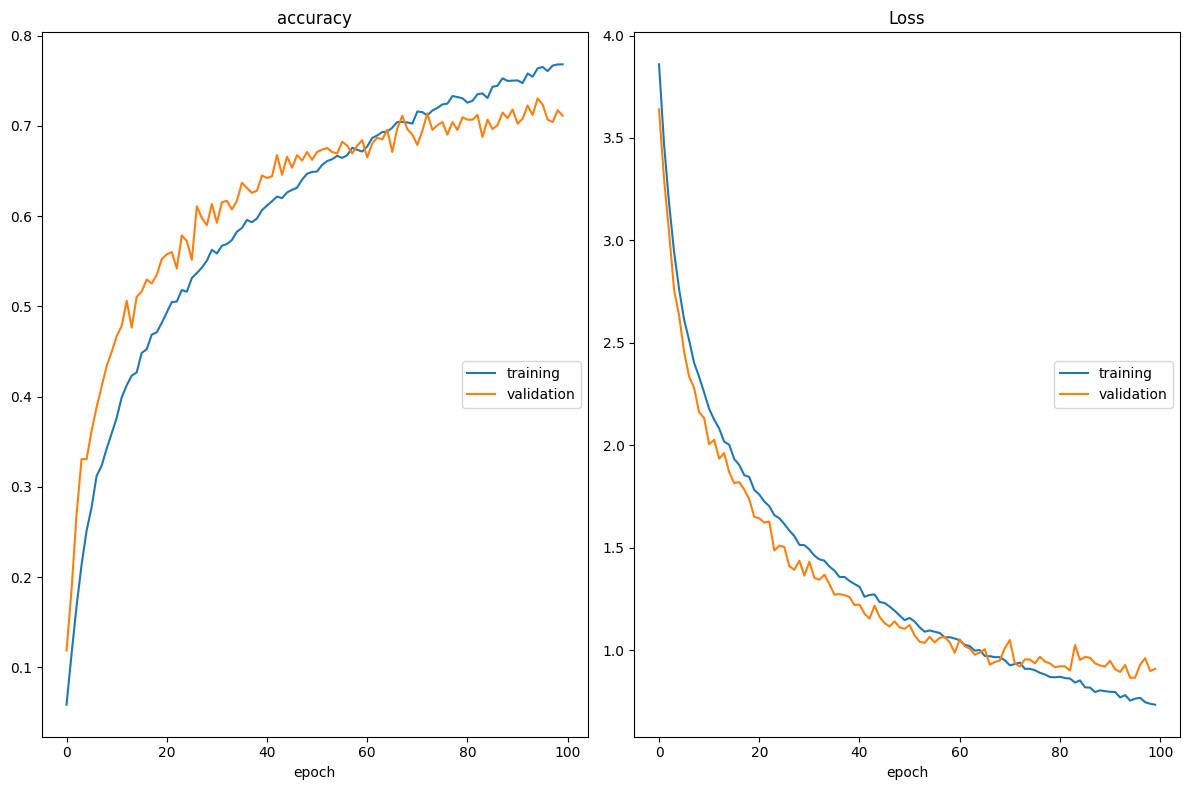

accuracy
	training         	 (min:    0.059, max:    0.768, cur:    0.768)
	validation       	 (min:    0.119, max:    0.730, cur:    0.711)
Loss
	training         	 (min:    0.733, max:    3.859, cur:    0.733)
	validation       	 (min:    0.864, max:    3.640, cur:    0.908)
81/81 [==============================] - 12s 138ms/step - loss: 0.7331 - accuracy: 0.7681 - val_loss: 0.9078 - val_accuracy: 0.7112
CPU times: user 2h 18min 45s, sys: 3min 58s, total: 2h 22min 44s
Wall time: 21min 14s


In [ ]:
%%time

from livelossplot import PlotLossesKeras
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, PlotLossesKeras()],
)

In [ ]:
!pip install scikeras

In [ ]:
class_names

['VIVOSSPK01',
 'VIVOSSPK02',
 'VIVOSSPK03',
 'VIVOSSPK05',
 'VIVOSSPK04',
 'VIVOSSPK07',
 'VIVOSSPK06',
 'VIVOSSPK09',
 'VIVOSSPK10',
 'VIVOSSPK08',
 'VIVOSSPK12',
 'VIVOSSPK13',
 'VIVOSSPK11',
 'VIVOSSPK15',
 'VIVOSSPK14',
 'VIVOSSPK16',
 'VIVOSSPK20',
 'VIVOSSPK18',
 'VIVOSSPK22',
 'VIVOSSPK23',
 'VIVOSSPK17',
 'VIVOSSPK19',
 'VIVOSSPK21',
 'VIVOSSPK24',
 'VIVOSSPK25',
 'VIVOSSPK30',
 'VIVOSSPK26',
 'VIVOSSPK27',
 'VIVOSSPK32',
 'VIVOSSPK28',
 'VIVOSSPK31',
 'VIVOSSPK33',
 'VIVOSSPK29',
 'VIVOSSPK34',
 'VIVOSSPK35',
 'VIVOSSPK40',
 'VIVOSSPK43',
 'VIVOSSPK38',
 'VIVOSSPK37',
 'VIVOSSPK36',
 'VIVOSSPK42',
 'VIVOSSPK41',
 'VIVOSSPK39',
 'VIVOSSPK45',
 'VIVOSSPK44',
 'VIVOSSPK46']

In [ ]:
# Create a dictionary mapping class names to labels
class_name_to_label = {class_names[i]: i for i in range(len(class_names))}

# Print class_names and their encoded labels
for class_name, label in class_name_to_label.items():
    print(f"Class Name: {class_name}, Encoded Label: {label}")


Class Name: VIVOSSPK01, Encoded Label: 0
Class Name: VIVOSSPK02, Encoded Label: 1
Class Name: VIVOSSPK03, Encoded Label: 2
Class Name: VIVOSSPK05, Encoded Label: 3
Class Name: VIVOSSPK04, Encoded Label: 4
Class Name: VIVOSSPK07, Encoded Label: 5
Class Name: VIVOSSPK06, Encoded Label: 6
Class Name: VIVOSSPK09, Encoded Label: 7
Class Name: VIVOSSPK08, Encoded Label: 8


## Model V5

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
# Define the learning rate you want to use
custom_learning_rate = 0.0001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)

model.compile(
    optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_model_v4.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_109 (Conv1D)         (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 dropout_60 (Dropout)        (None, 8000, 16)             0         ['conv1d_109[0][0]']          
                                                                                                  
 activation_78 (Activation)  (None, 8000, 16)             0         ['dropout_60[0][0]']          
                                                                                            

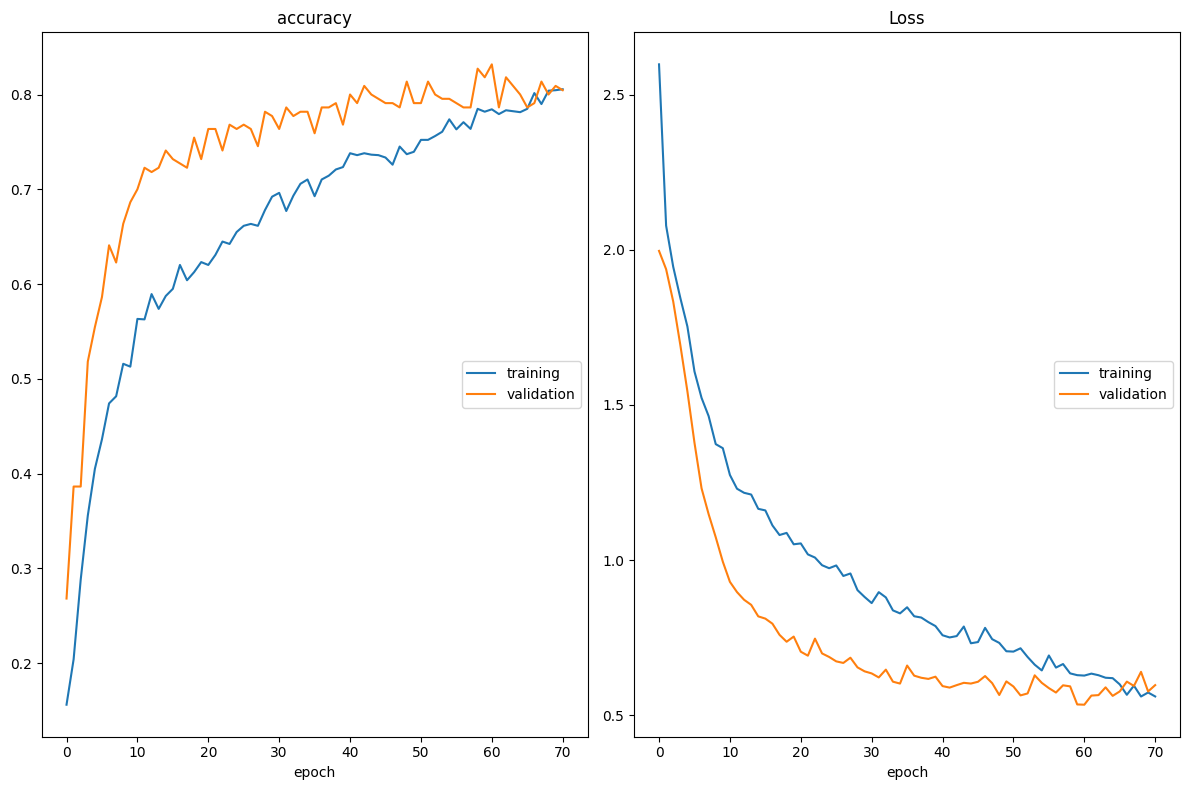

accuracy
	training         	 (min:    0.156, max:    0.806, cur:    0.806)
	validation       	 (min:    0.268, max:    0.832, cur:    0.805)
Loss
	training         	 (min:    0.560, max:    2.598, cur:    0.560)
	validation       	 (min:    0.534, max:    1.997, cur:    0.597)
16/16 [==============================] - 3s 133ms/step - loss: 0.5601 - accuracy: 0.8055 - val_loss: 0.5966 - val_accuracy: 0.8045
CPU times: user 18min 40s, sys: 48.5 s, total: 19min 28s
Wall time: 4min 17s


In [ ]:
%%time
EPOCHS = 200
from livelossplot import PlotLossesKeras
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb, PlotLossesKeras()],
)

In [ ]:
print(model.evaluate(valid_ds))

7/7 [==============================] - 0s 13ms/step - loss: 0.5335 - accuracy: 0.8318
[0.5335181951522827, 0.831818163394928]


In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)

    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]
    print(y_pred)
    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        print(class_names[labels[index]])
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 0s 5ms/step
[4 4 4 8 1 7 1 7 5 7]
Speaker: VIVOSSPK04	Predicted: VIVOSSPK04
VIVOSSPK04


Speaker: VIVOSSPK04	Predicted: VIVOSSPK04
VIVOSSPK04


Speaker: VIVOSSPK04	Predicted: VIVOSSPK04
VIVOSSPK04


Speaker: VIVOSSPK08	Predicted: VIVOSSPK08
VIVOSSPK08


Speaker: VIVOSSPK02	Predicted: VIVOSSPK02
VIVOSSPK02


Speaker: VIVOSSPK09	Predicted: VIVOSSPK09
VIVOSSPK09


Speaker: VIVOSSPK05	Predicted: VIVOSSPK02
VIVOSSPK05


Speaker: VIVOSSPK08	Predicted: VIVOSSPK09
VIVOSSPK08


Speaker: VIVOSSPK07	Predicted: VIVOSSPK07
VIVOSSPK07


Speaker: VIVOSSPK09	Predicted: VIVOSSPK09
VIVOSSPK09


## Languagemodel adding


In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Dropout(0.2)(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
# Define the learning rate you want to use
custom_learning_rate = 0.0001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)

model.compile(
    optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/drive/MyDrive/Master/VoiceProcessing/cnn_language_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 dropout_10 (Dropout)        (None, 8000, 16)             0         ['conv1d_19[0][0]']           
                                                                                                  
 activation_13 (Activation)  (None, 8000, 16)             0         ['dropout_10[0][0]']          
                                                                                            

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
num_vocab = 10000  # Số lượng từ trong từ vựng của mô hình ngôn ngữ
embedding_dim = 128  # Kích thước embedding cho từng từ
num_classes = 46
# Define the language model input layer and its architecture
language_input = keras.layers.Input(shape=(100,), name="language_input")
language_x = keras.layers.Embedding(input_dim=num_vocab, output_dim=embedding_dim)(language_input)
language_x = keras.layers.LSTM(64)(language_x)

# Merge the language model output with the acoustic model output
merged_output = keras.layers.Concatenate()([model.output, language_x])

# Add some dense layers for combined processing
x = keras.layers.Dense(256, activation="relu")(merged_output)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)

# Define the final output layer
lang_outputs = keras.layers.Dense(num_classes, activation="softmax", name="language_output")(x)

# Create the combined model
combined_model = keras.models.Model(inputs=[model.input, language_input], outputs=[model.output, lang_outputs])
combined_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_19 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 dropout_10 (Dropout)        (None, 8000, 16)             0         ['conv1d_19[0][0]']           
                                                                                                  
 activation_13 (Activation)  (None, 8000, 16)             0         ['dropout_10[0][0]']          
                                                                                            

In [ ]:
# Compile the combined model
custom_learning_rate = 0.0001  # Replace with your desired learning rate
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=custom_learning_rate)
combined_model.compile(optimizer=custom_optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])




In [ ]:
# Load the contents of the 'prompt.txt' file
with open('/content/drive/MyDrive/Master/VoiceProcessing/Dataset/prompts.txt', 'r') as file:
    prompts = file.read().split('\n')

# Extract the speaker name from each line in the prompt file
speaker_names = [line.split(' ')[0] for line in prompts]

# Create a dataset from the speaker names
language_ds = tf.data.Dataset.from_tensor_slices(speaker_names)

# You can also preprocess the language data as needed
# For example, if you need to one-hot encode the speaker names
# you can do that here.
# language_ds = language_ds.map(lambda x: one_hot_encode(x))

# Make sure the dataset is properly batched and prefetched
language_ds = language_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
with open('/content/drive/MyDrive/Master/VoiceProcessing/Dataset/prompts.txt', 'r') as file:
    prompts = file.read().split('\n')

speaker_to_data = {}

for line in prompts:
    parts = line.split(' ')
    if len(parts) >= 2:
        speaker = parts[0]
        data = ' '.join(parts[1:])
        speaker_to_data[speaker] = data

print(speaker_to_data)



{'VIVOSSPK01_R001': 'KHÁCH SẠN', 'VIVOSSPK01_R002': 'CHỈ BẰNG CÁCH LUÔN NỖ LỰC THÌ CUỐI CÙNG BẠN MỚI ĐƯỢC ĐỀN ĐÁP', 'VIVOSSPK01_R003': 'TRONG SỐ CÁC QUỐC GIA CÔNG NGHIỆP PHÁT TRIỂN', 'VIVOSSPK01_R004': 'ANH ĐÃ NHÌN THẤY TRONG NHỮNG LẢI NHẢI DÔNG DÀI CỦA NHU', 'VIVOSSPK01_R005': 'KHỦNG HOẢNG MÔI TRƯỜNG CẦN ĐƯỢC NGĂN CHẶN', 'VIVOSSPK01_R006': 'TRÔNG THẤY TÀU CÁ ĐẰNG XA ANH ĐÃ ẤN CÒI CẢNH BÁO', 'VIVOSSPK01_R007': 'MẤY SÀO RUỘNG CỦA GIA ĐÌNH ÔNG ĐÀNH BỎ HOANG CHO CỎ MỌC', 'VIVOSSPK01_R008': 'CÓ ĐÊM GẶP PHẢI HEO NỌC NÓ RƯỢT', 'VIVOSSPK01_R009': 'CÁC BÀN HỌC NHỎ HẰNG NGÀY NAY TRỞ THÀNH BÀN THỜ CỦA CÁC CHÁU', 'VIVOSSPK01_R010': 'CHA MẸ TÔI THƯỜNG CHÌ CHIẾT NHAU BẰNG NHỮNG LỜI LẼ KHÓ NGHE', 'VIVOSSPK01_R011': 'HẤP DẪN NHẤT LÀ CUỘC THI BƠI THUYỀN TRUYỀN THỐNG', 'VIVOSSPK01_R012': 'VỚI NHỮNG CỜ LÍP NHẠC TRUYỀN HÌNH', 'VIVOSSPK01_R013': 'MỘT TRONG NHỮNG CÁCH TỐT NHẤT', 'VIVOSSPK01_R014': 'ĂN CẮP PHỖNG TƯỢNG', 'VIVOSSPK01_R015': 'TỚI VỖ VAI HỎI VỀ CHIẾC ÁO MỚI MUA', 'VIVOSSPK01_R016': 'BÀO CHẾ NHỮ

In [ ]:
# Tạo tập dữ liệu ngôn ngữ cho training và validation
train_language_speakers = [os.path.splitext(os.path.basename(speaker))[0] for speaker in train_audio_paths]
valid_language_speakers = [os.path.splitext(os.path.basename(speaker))[0] for speaker in valid_audio_paths]

train_language_data = [speaker_to_data[speaker] for speaker in train_language_speakers]
valid_language_data = [speaker_to_data[speaker] for speaker in valid_language_speakers]

# Chuyển đổi thành TensorFlow Dataset
train_language_ds = tf.data.Dataset.from_tensor_slices(train_language_data)
valid_language_ds = tf.data.Dataset.from_tensor_slices(valid_language_data)


In [ ]:
valid_language_data

['KHÔNG THỂ KÉO LÊN LOẠI GIỎI NHƯ NHỮNG NGƯỜI KHÁC ĐƯỢC',
 'ỔNG PHONG ĐỘ RA CÒN TÔI LẠI GIÀ ĐI',
 'TÁCH BIỆT VỚI CĂN PHÒNG MÀ BẠN ĐANG Ở BÂY GIỜ',
 'ĐÂY LÀ CÔNG NGHỆ LÀM MUỐI MỚI ĐÃ ĐƯỢC THỬ NGHIỆM VÀO VỤ TRƯỚC VÀ CHO KẾT QUẢ KHẢ QUAN',
 'NĂM MƯƠI HAI NĂM MƯƠI BA',
 'TA LÀ BÒ CẠP HAY THIÊN BÌNH',
 'ĐÓ LÀ ÔNG THẦY NGƯỜI BỒ ĐÀO NHA NÀY XIN MUA NĂM CHIẾC XE LĂN',
 'NẾU GÂY RA HẬU QUẢ CŨNG PHẢI BỒI THƯỜNG CHO DÂN',
 'ĐỨNG BA CA LẬN VỚI LẠI ĐEN CHO RẮN RỎI THÊM LO GÌ',
 'NGƯỜI TÀI XẾ TRONG XE BẮT ĐẦU NHẤN CÒI INH ỎI',
 'ĐỘNG THÁI NÀY CỦA HÃNG NHẰM THU HÚT THÊM NGƯỜI DÙNG',
 'TÁM MƯƠI TÁM TÁM MƯƠI CHÍN',
 'VÌ CHÚNG TRƠ TRẼN VÀ KHÔNG THỂ CHẤP NHẬN',
 'VÁY VẪN GIỮ VỊ TRÍ QUAN TRỌNG TRONG NHỮNG KIỂU ÁO MÙA THU',
 'DO VẬY TRƯỚC MẮT CHƯA ĐẶT VẤN ĐỀ CẤM KINH DOANH DỊCH VỤ NÀY',
 'TÓM LẠI BIẾT CÓ NGUY HIỂM MÀ KHÔNG CẢNH BÁO PHÒNG NGỪA CŨNG ĐÁNG TRÁCH KHÔNG KÉM',
 'BÁN GIÁ NÀY CHÓ NÓ MUA',
 'TÔI KHÔNG BIẾT PHẢI GIẢI THÍCH LÀM SAO NHƯNG BA MẸ TÔI RẤT KHÓ LUÔN SỬA TỪNG HÀNH ĐỘNG CÂU NÓI CỦA TÔI MỖI KH

In [ ]:
print("Number of elements in train_language_data: ", len(train_language_data))
print("Number of elements in valid_language_data: ", len(valid_language_data))


Number of elements in train_language_data:  10494
Number of elements in valid_language_data:  1166


In [ ]:
def preprocess_new_audio(audio_file_path, input_shape):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(audio_file_path), 1, 16000)
    audio_data = audio.numpy()


    if audio_data.shape[0] < input_shape[0]:
        # Pad with zeros at the end
        pad_length = input_shape[0] - audio_data.shape[0]
        audio_data = np.pad(audio_data, ((0, pad_length), (0, 0)), mode='constant')
    elif audio_data.shape[0] > input_shape[0]:
        # Trim the audio if it's longer
        audio_data = audio_data[:input_shape[0], :]

    audio_data = audio_data.reshape((1, *input_shape))
    return audio_data

SAMPLING_RATE = 16000

new_audio_file_path = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/audio_testing/VIVOSSPK08_T046.wav"
input_shape = (SAMPLING_RATE // 2, 1)


new_audio = preprocess_new_audio(new_audio_file_path, input_shape)

# Predict the class of the new audio
predicted_probabilities = model.predict(new_audio)
predicted_class_index = np.argmax(predicted_probabilities, axis=-1)
predicted_class_index = int(predicted_class_index)
predicted_class_name = class_names[predicted_class_index]

print("Predicted Class:", predicted_class_name)

1/1 [==============================] - 0s 25ms/step
Predicted Class: VIVOSSPK07


In [ ]:
_# Define a function to load and preprocess a new audio file
# Define a function to load and preprocess a new audio file
def preprocess_new_audio(audio_file_path, input_shape):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(audio_file_path), 1, 16000)

    # Extract the audio data as a NumPy array
    audio_data = audio.numpy()

    # Ensure the audio data has the expected shape or pad it if needed
    if audio_data.shape[0] < input_shape[0]:
        # Pad with zeros at the end
        pad_length = input_shape[0] - audio_data.shape[0]
        audio_data = np.pad(audio_data, ((0, pad_length), (0, 0)), mode='constant')
    elif audio_data.shape[0] > input_shape[0]:
        # Trim the audio if it's longer
        audio_data = audio_data[:input_shape[0], :]

    # Add a batch dimension
    audio_data = audio_data.reshape((1, *input_shape))

    return audio_data

SAMPLING_RATE = 16000
# Path to the new audio file you want to predict
new_audio_file_path = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/audio_testing/VIVOSSPK08_T046.wav"

# Define the expected input shape for the model
input_shape = (SAMPLING_RATE // 2, 1)

# Preprocess the new audio
new_audio = preprocess_new_audio(new_audio_file_path, input_shape)

# Predict the class of the new audio
predicted_probabilities = model.predict(new_audio)
predicted_class_index = np.argmax(predicted_probabilities, axis=-1)
predicted_class_index = int(predicted_class_index)
# Map the predicted class index to a class name using your class_names list or dictionary
#class_names = ["Class1", "Class2", "Class3", ...]  # Replace with your class names
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class_name)

In [ ]:
new_audio_file_path = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/audio_testing/VIVOSSPK01_T046.wav"


new_audio = path_to_audio(new_audio_file_path)
new_audio = tf.expand_dims(new_audio, axis=0)
new_fft = audio_to_fft(new_audio)

y_pred = model.predict(new_fft)
predicted_label = np.argmax(y_pred, axis=-1)
predicted_speaker = class_names[predicted_label[0]]

print("Predicted speaker: {}".format(predicted_speaker))
#display(Audio(new_audio.squeeze(), rate=SAMPLING_RATE))

1/1 [==============================] - 0s 22ms/step
Predicted speaker: VIVOSSPK01


In [ ]:
new_audio_file_path = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/audio_testing/VIVOSSPK01_T046.wav"

# Load and preprocess the new audio file
new_audio = path_to_audio(new_audio_file_path)
#new_audio = add_noise(new_audio, noises, scale=SCALE)
new_audio = tf.expand_dims(new_audio, axis=0)  # Add batch dimension
new_fft = audio_to_fft(new_audio)

# Predict
y_pred = model.predict(new_fft)
predicted_label = np.argmax(y_pred, axis=-1)
predicted_speaker = class_names[predicted_label[0]]

# Display the predicted result
print("Predicted speaker: {}".format(predicted_speaker))
#display(Audio(new_audio.squeeze(), rate=SAMPLING_RATE))

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
person1_file = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio/VIVOSSPK01/VIVOSSPK01_R001.wav"
person2_file = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio/VIVOSSPK02/VIVOSSPK02_R001.wav"
person3_file = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio/VIVOSSPK03/VIVOSSPK03_R003.wav"
person4_file = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio/VIVOSSPK04/VIVOSSPK04_R003.wav"
person5_file = "/content/drive/MyDrive/Master/VoiceProcessing/Dataset/DataViVos/audio/VIVOSSPK05/VIVOSSPK05_R001.wav"

In [ ]:
ipd.Audio(person1_file)

In [ ]:
ipd.Audio(person2_file)

In [ ]:
ipd.Audio(person3_file)

In [ ]:
ipd.Audio(person4_file)

In [ ]:
ipd.Audio(person5_file)

In [ ]:
person1, sr = librosa.load(person1_file, duration=3)
person2, _ = librosa.load(person2_file, duration=3)
person3, _ = librosa.load(person3_file, duration=3)
person4, _ = librosa.load(person4_file, duration=3)
person5, _ = librosa.load(person5_file, duration=3)

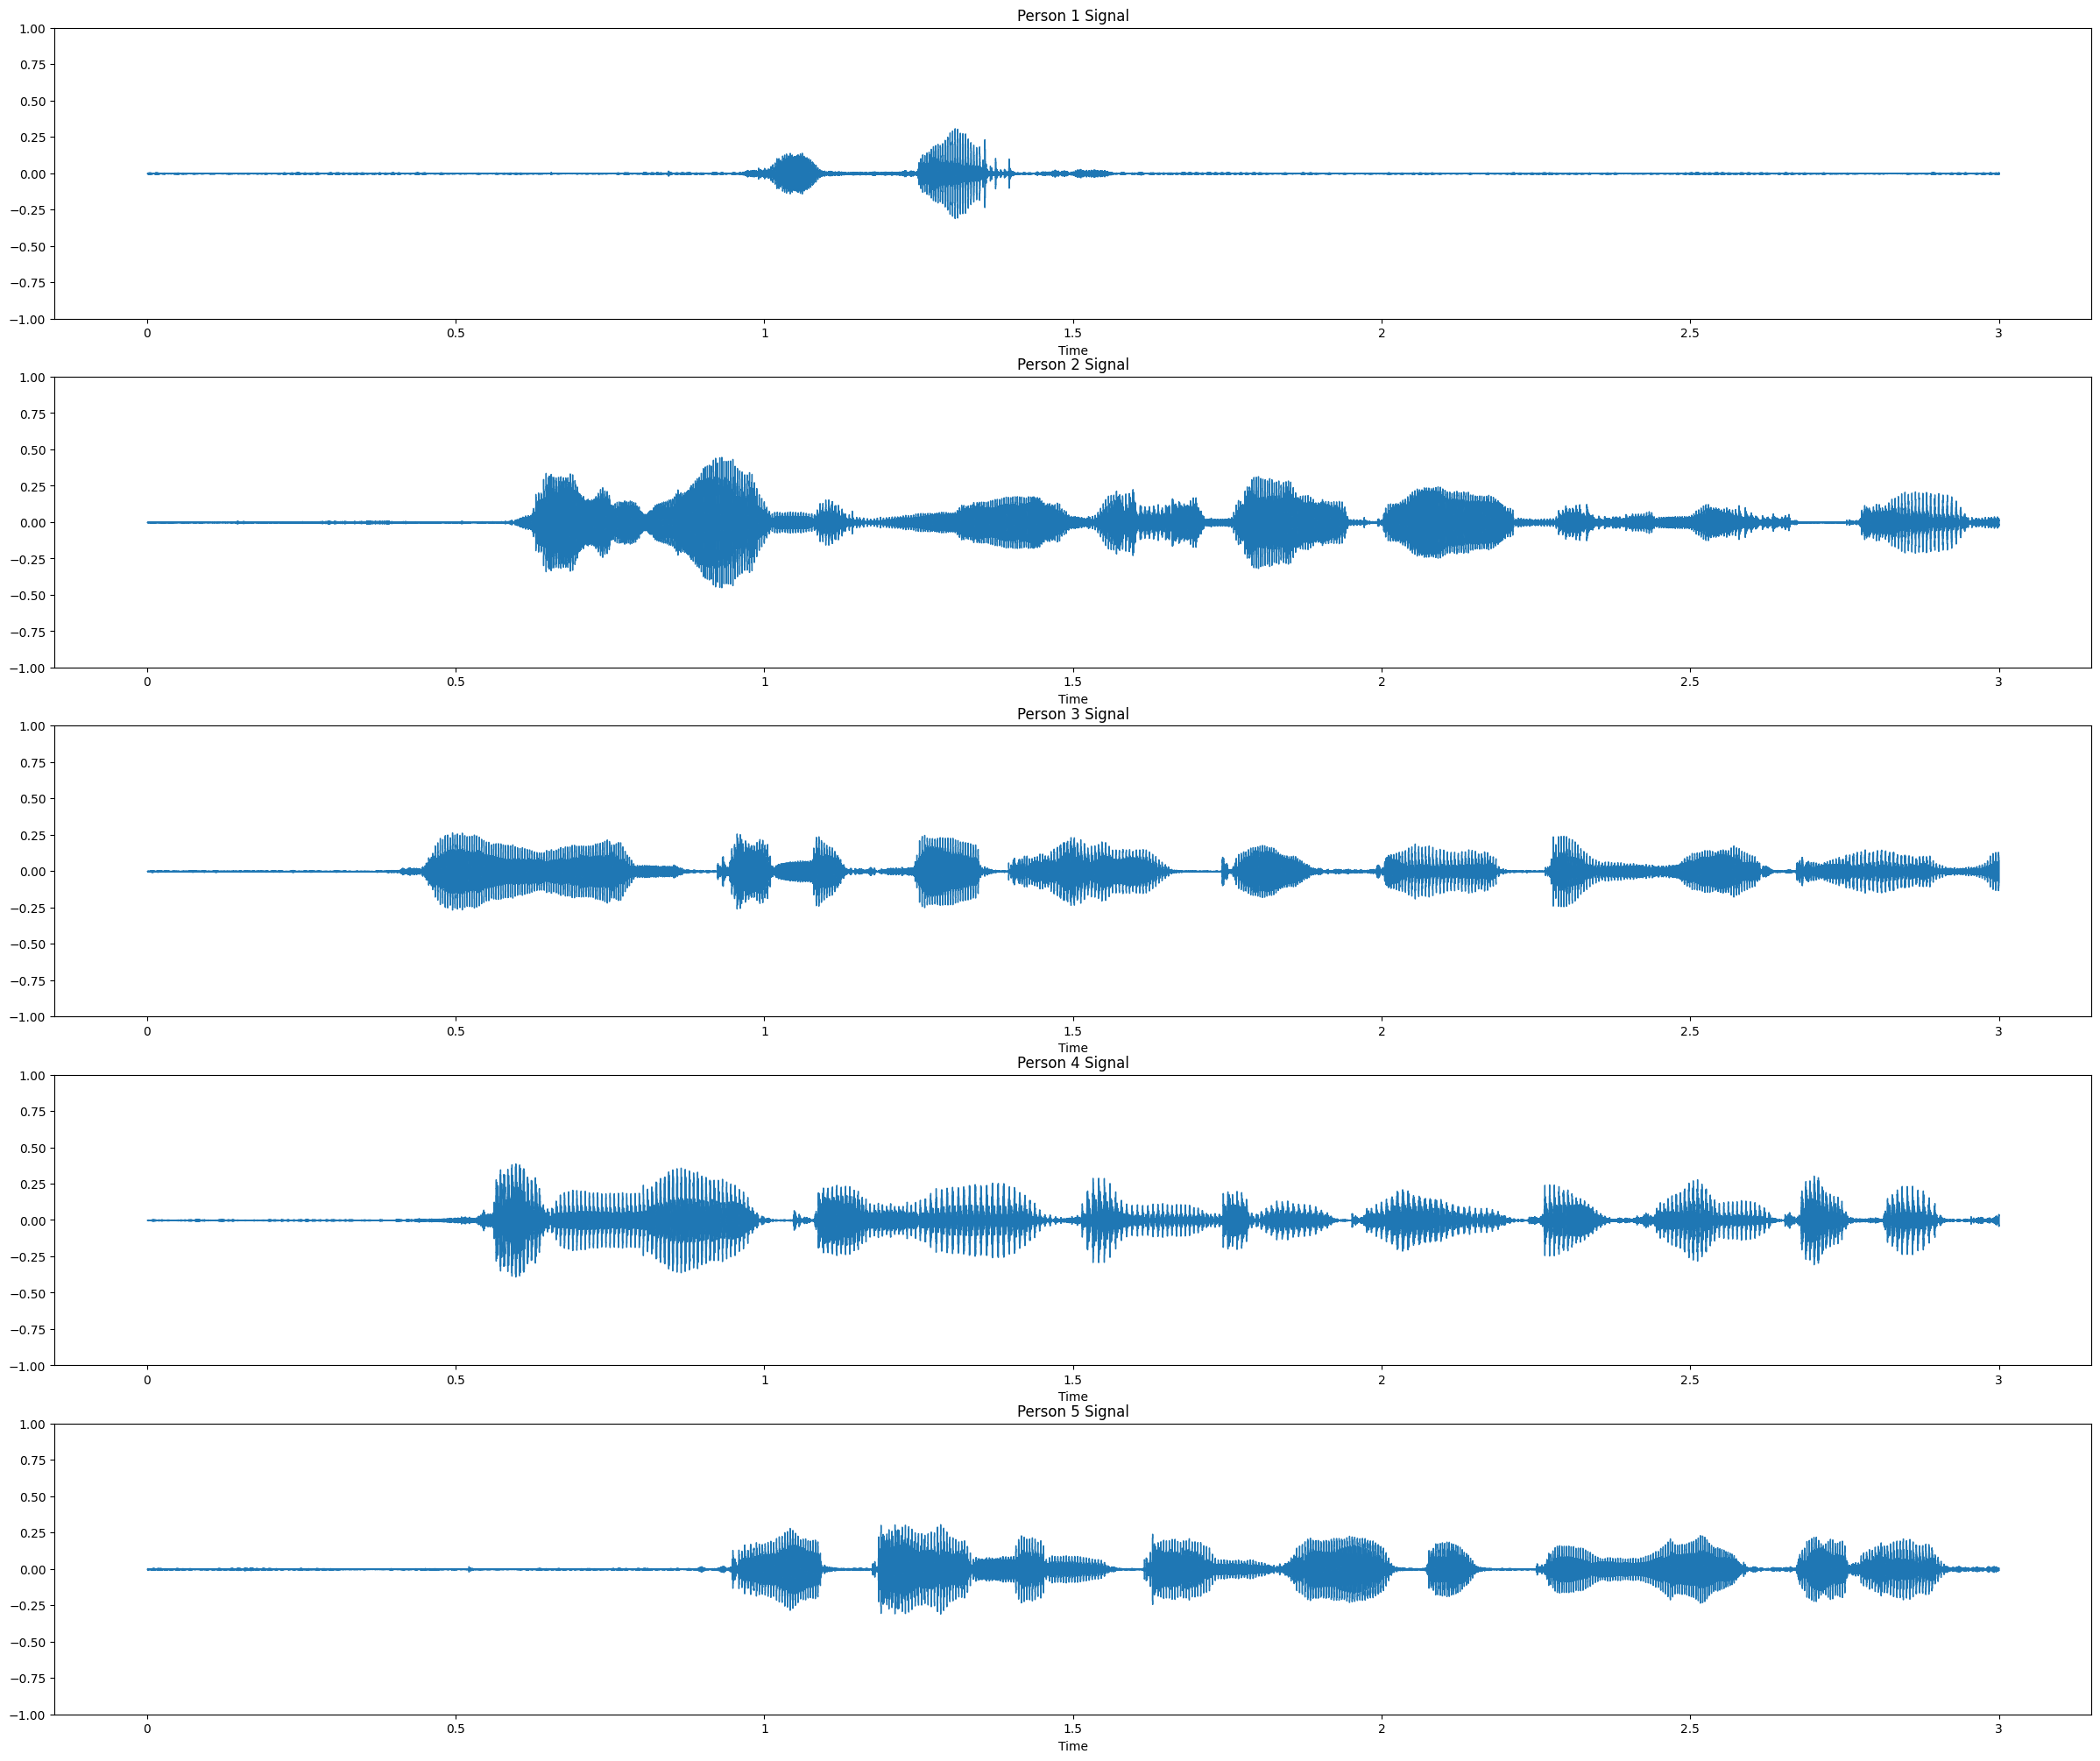

In [ ]:
plt.figure(figsize = (30,25))
plt.subplot(5,1,1)
librosa.display.waveshow(person1)
plt.title("Person 1 Signal")
plt.ylim((-1,1))

plt.subplot(5,1,2)
librosa.display.waveshow(person2)
plt.title("Person 2 Signal")
plt.ylim((-1,1))

plt.subplot(5,1,3)
librosa.display.waveshow(person3)
plt.title("Person 3 Signal")
plt.ylim((-1,1))

plt.subplot(5,1,4)
librosa.display.waveshow(person4)
plt.title("Person 4 Signal")
plt.ylim((-1,1))

plt.subplot(5,1,5)
librosa.display.waveshow(person5)
plt.title("Person 5 Signal")
plt.ylim((-1,1))

plt.show()

In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

#Calculate the amplitude envelope
def amplitude_envelope(signal, frame_size, hop_length):
    amplitude_envelope = []
    # calculate AE for each frame
    for i in range(0,len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_envelope)

    return np.array(amplitude_envelope)

In [ ]:
ae_person1 = amplitude_envelope(person1, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
ae_person2 = amplitude_envelope(person2, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
ae_person3 = amplitude_envelope(person3, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
ae_person4 = amplitude_envelope(person4, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)
ae_person5 = amplitude_envelope(person5, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH)

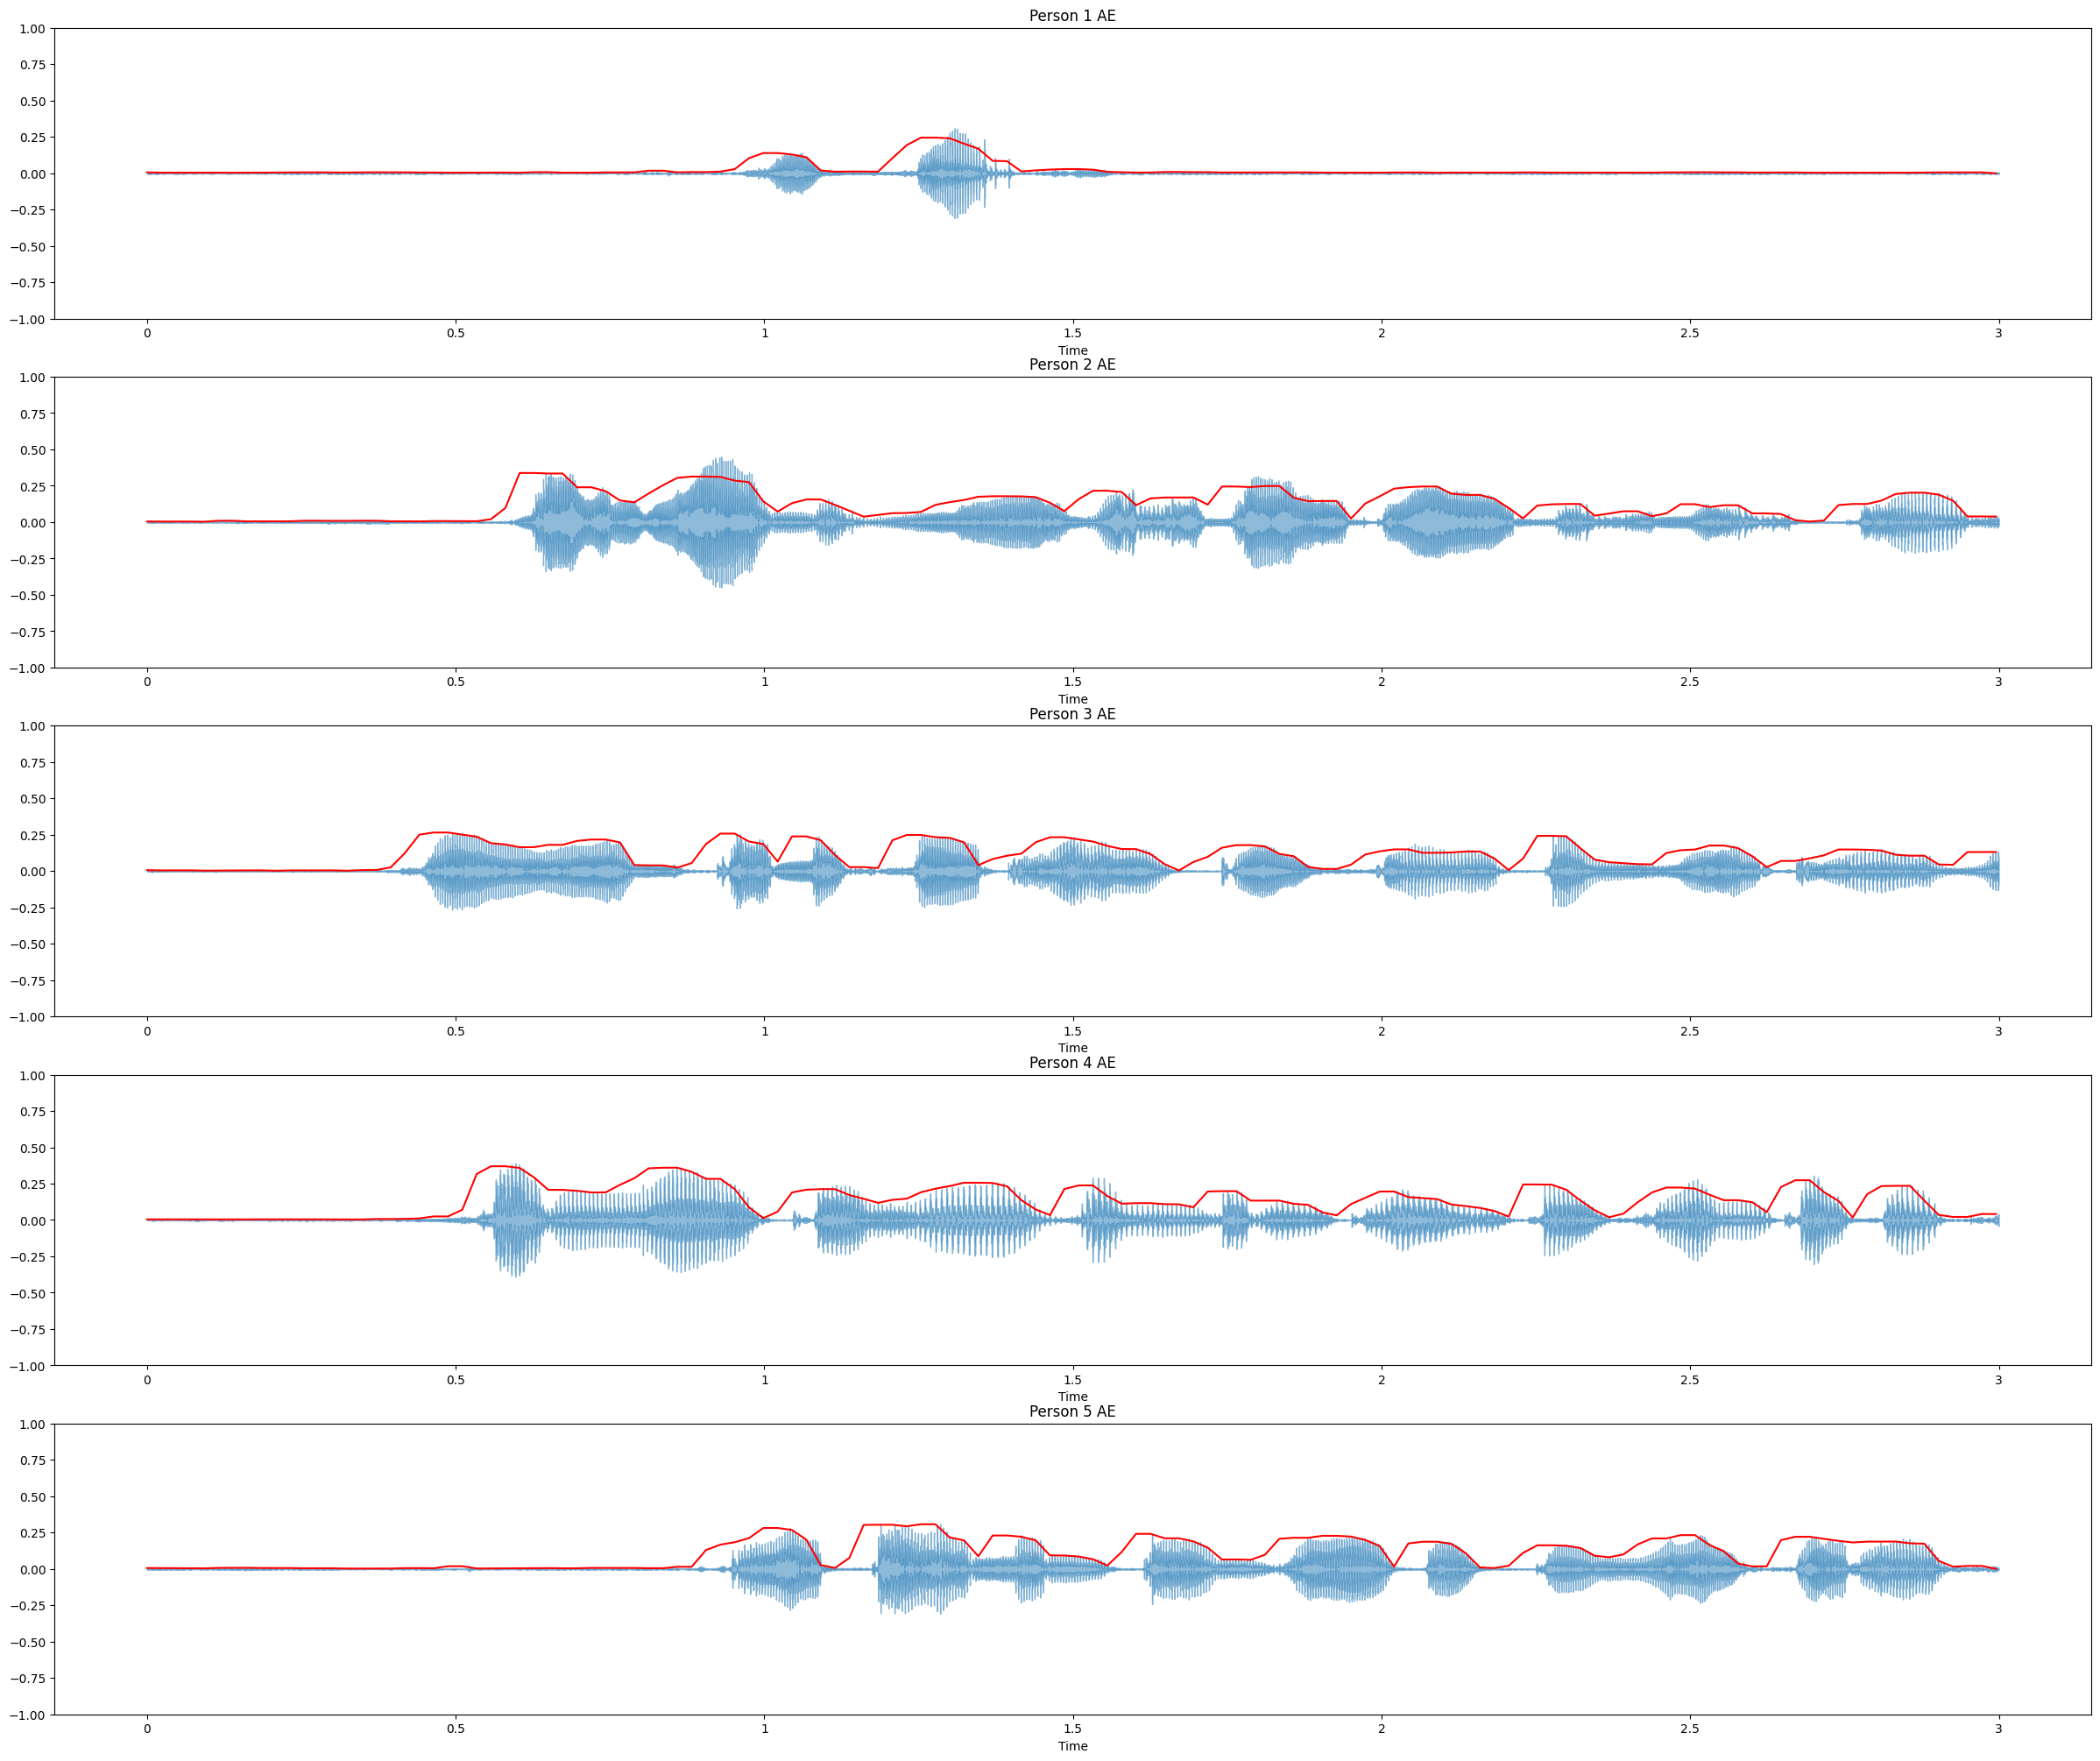

In [ ]:
# visualise the amplitude envelope for all the audio files

frames = range(0, ae_person1.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.figure(figsize = (30,25))
plt.subplot(5,1,1)
librosa.display.waveshow(person1, alpha=0.5)
plt.plot(t, ae_person1, color="r")
plt.title("Person 1 AE")
plt.ylim((-1,1))

plt.subplot(5,1,2)
librosa.display.waveshow(person2, alpha=0.5)
plt.plot(t, ae_person2, color="r")
plt.title("Person 2 AE")
plt.ylim((-1,1))

plt.subplot(5,1,3)
librosa.display.waveshow(person3, alpha=0.5)
plt.plot(t, ae_person3, color="r")
plt.title("Person 3 AE")
plt.ylim((-1,1))

plt.subplot(5,1,4)
librosa.display.waveshow(person4, alpha=0.5)
plt.plot(t, ae_person4, color="r")
plt.title("Person 4 AE")
plt.ylim((-1,1))

plt.subplot(5,1,5)
librosa.display.waveshow(person5, alpha=0.5)
plt.plot(t, ae_person5, color="r")
plt.title("Person 5 AE")
plt.ylim((-1,1))

plt.show()

In [ ]:
rms_person1 = librosa.feature.rms(y=person1, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_person2 = librosa.feature.rms(y=person2, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_person3 = librosa.feature.rms(y=person3, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_person4 = librosa.feature.rms(y=person4, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_person5 = librosa.feature.rms(y=person5, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

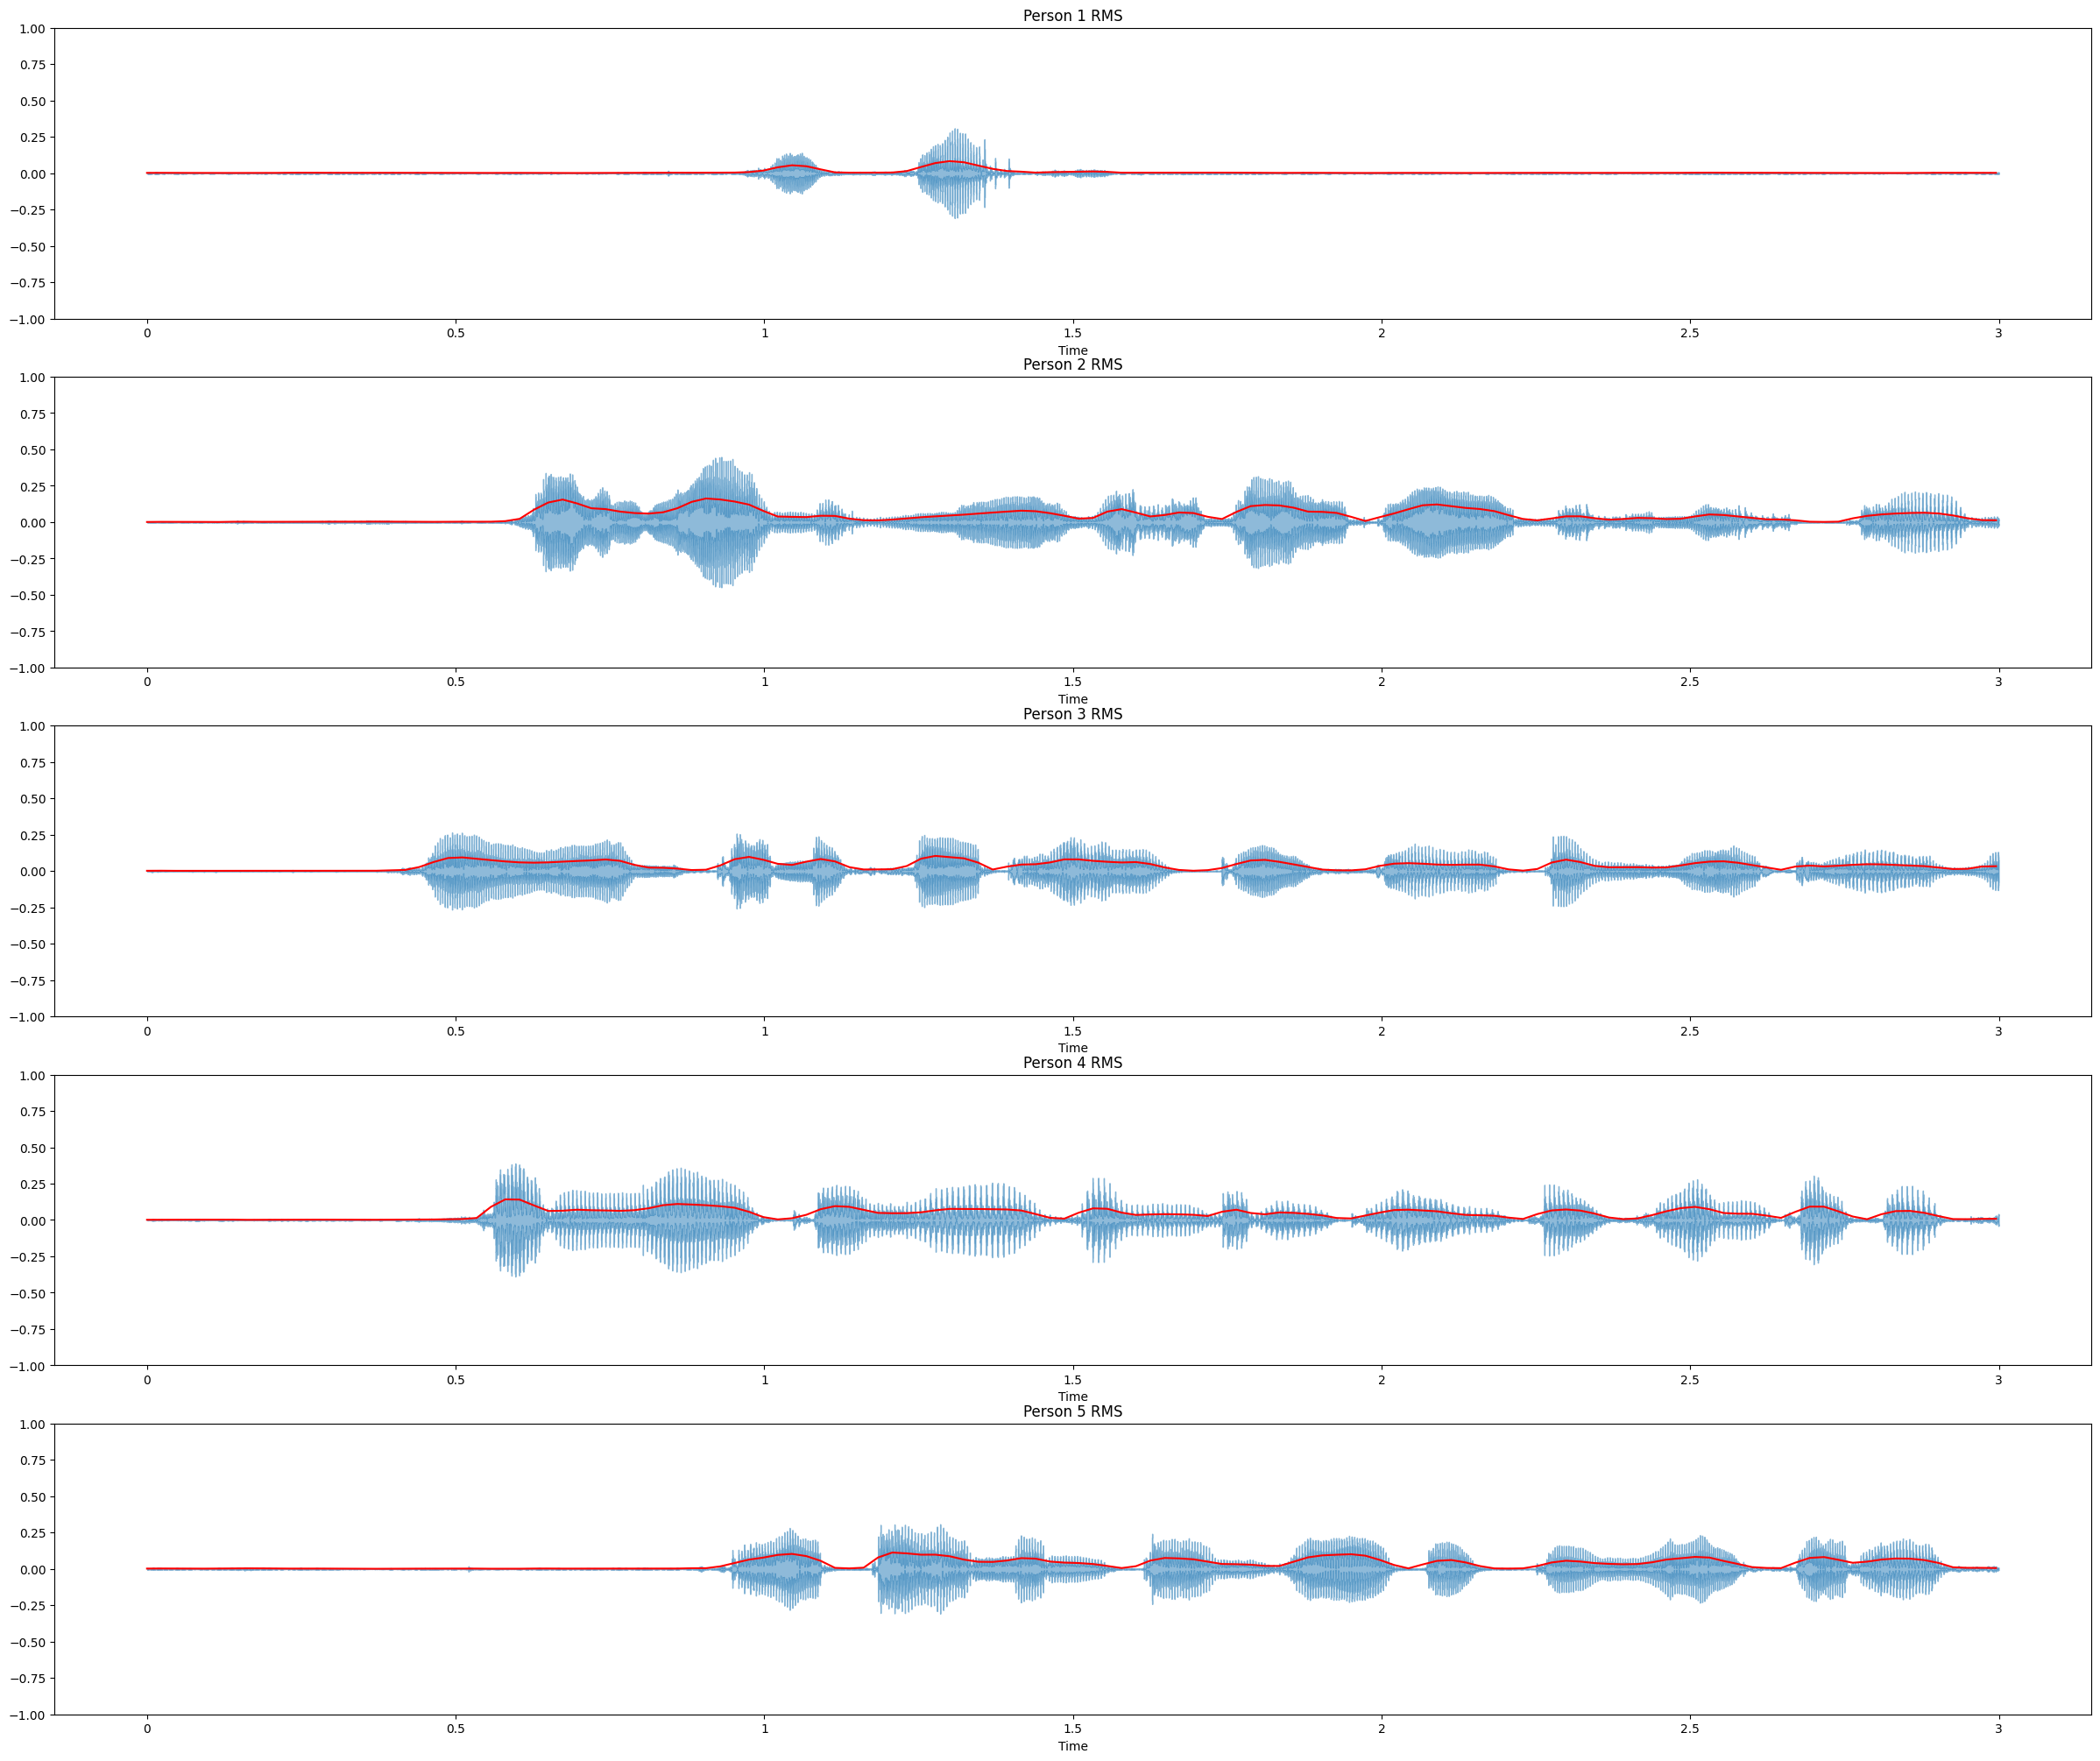

In [ ]:
plt.figure(figsize = (30,25))
plt.subplot(5,1,1)
librosa.display.waveshow(person1, alpha=0.5)
plt.plot(t, rms_person1, color="r")
plt.title("Person 1 RMS")
plt.ylim((-1,1))

plt.subplot(5,1,2)
librosa.display.waveshow(person2, alpha=0.5)
plt.plot(t, rms_person2, color="r")
plt.title("Person 2 RMS")
plt.ylim((-1,1))

plt.subplot(5,1,3)
librosa.display.waveshow(person3, alpha=0.5)
plt.plot(t, rms_person3, color="r")
plt.title("Person 3 RMS")
plt.ylim((-1,1))

plt.subplot(5,1,4)
librosa.display.waveshow(person4, alpha=0.5)
plt.plot(t, rms_person4, color="r")
plt.title("Person 4 RMS")
plt.ylim((-1,1))

plt.subplot(5,1,5)
librosa.display.waveshow(person5, alpha=0.5)
plt.plot(t, rms_person5, color="r")
plt.title("Person 5 RMS")
plt.ylim((-1,1))

plt.show()

In [ ]:
zcr_person1 = librosa.feature.zero_crossing_rate(y=person1, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_person2 = librosa.feature.zero_crossing_rate(y=person2, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_person3 = librosa.feature.zero_crossing_rate(y=person3, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_person4 = librosa.feature.zero_crossing_rate(y=person4, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_person5 = librosa.feature.zero_crossing_rate(y=person5, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

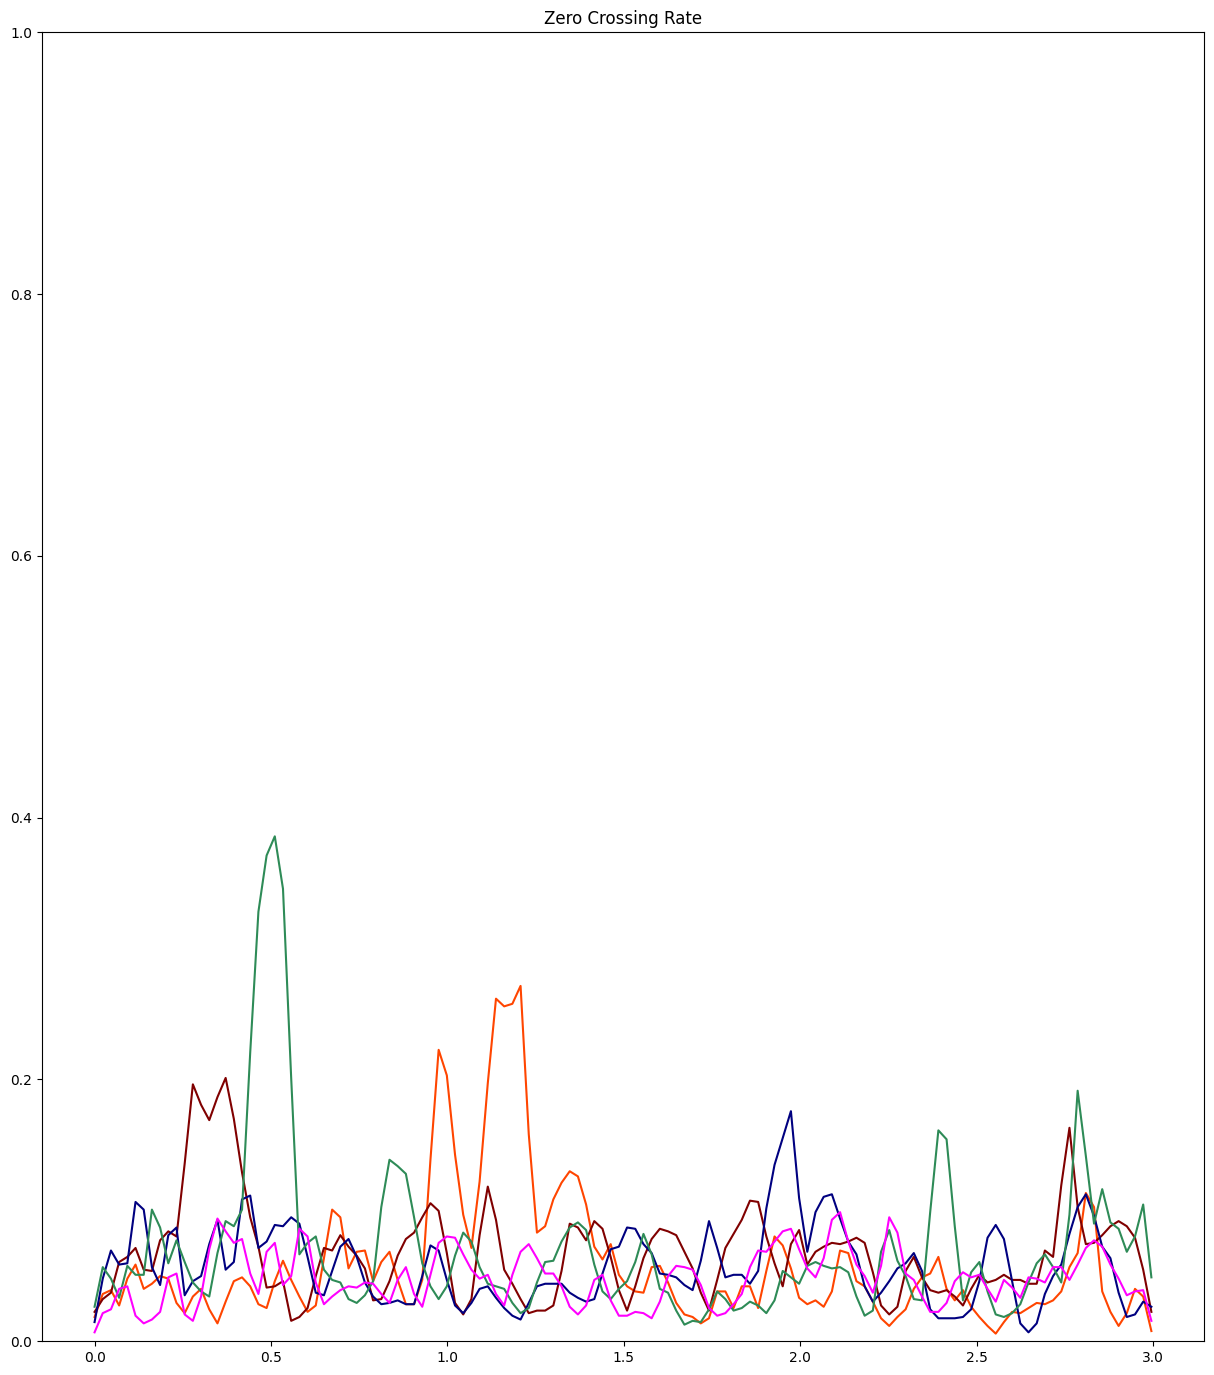

In [ ]:
plt.figure(figsize=(15,17))
plt.plot(t, zcr_person1, color="orangered")
plt.plot(t, zcr_person2, color="maroon")
plt.plot(t, zcr_person3, color="navy")
plt.plot(t, zcr_person4, color="seagreen")
plt.plot(t, zcr_person5, color="magenta")
plt.ylim((0,1))
plt.title("Zero Crossing Rate")

plt.show()

Fourier Transform

In [ ]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    #plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

In [ ]:
S_person1 = librosa.stft(person1, n_fft= FRAME_SIZE, hop_length=HOP_LENGTH)
S_person2 = librosa.stft(person2, n_fft= FRAME_SIZE, hop_length=HOP_LENGTH)
S_person3 = librosa.stft(person3, n_fft= FRAME_SIZE, hop_length=HOP_LENGTH)
S_person4 = librosa.stft(person4, n_fft= FRAME_SIZE, hop_length=HOP_LENGTH)
S_person5 = librosa.stft(person5, n_fft= FRAME_SIZE, hop_length=HOP_LENGTH)

In [ ]:
Y_person1 = librosa.power_to_db(np.abs(S_person1) ** 2)
Y_person2 = librosa.power_to_db(np.abs(S_person2) ** 2)
Y_person3 = librosa.power_to_db(np.abs(S_person3) ** 2)
Y_person4 = librosa.power_to_db(np.abs(S_person4) ** 2)
Y_person5 = librosa.power_to_db(np.abs(S_person5) ** 2)

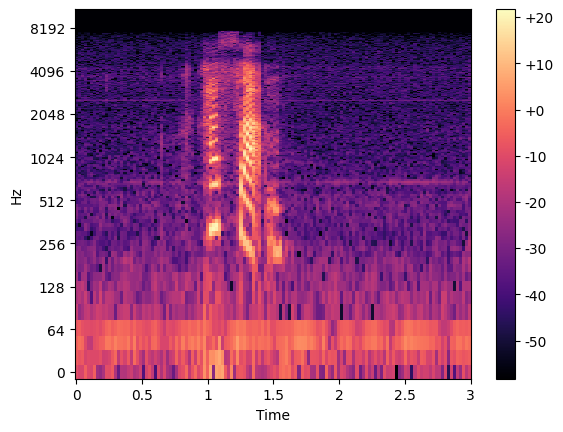

In [ ]:
plot_spectrogram(Y_person1, sr, HOP_LENGTH, y_axis= "log")

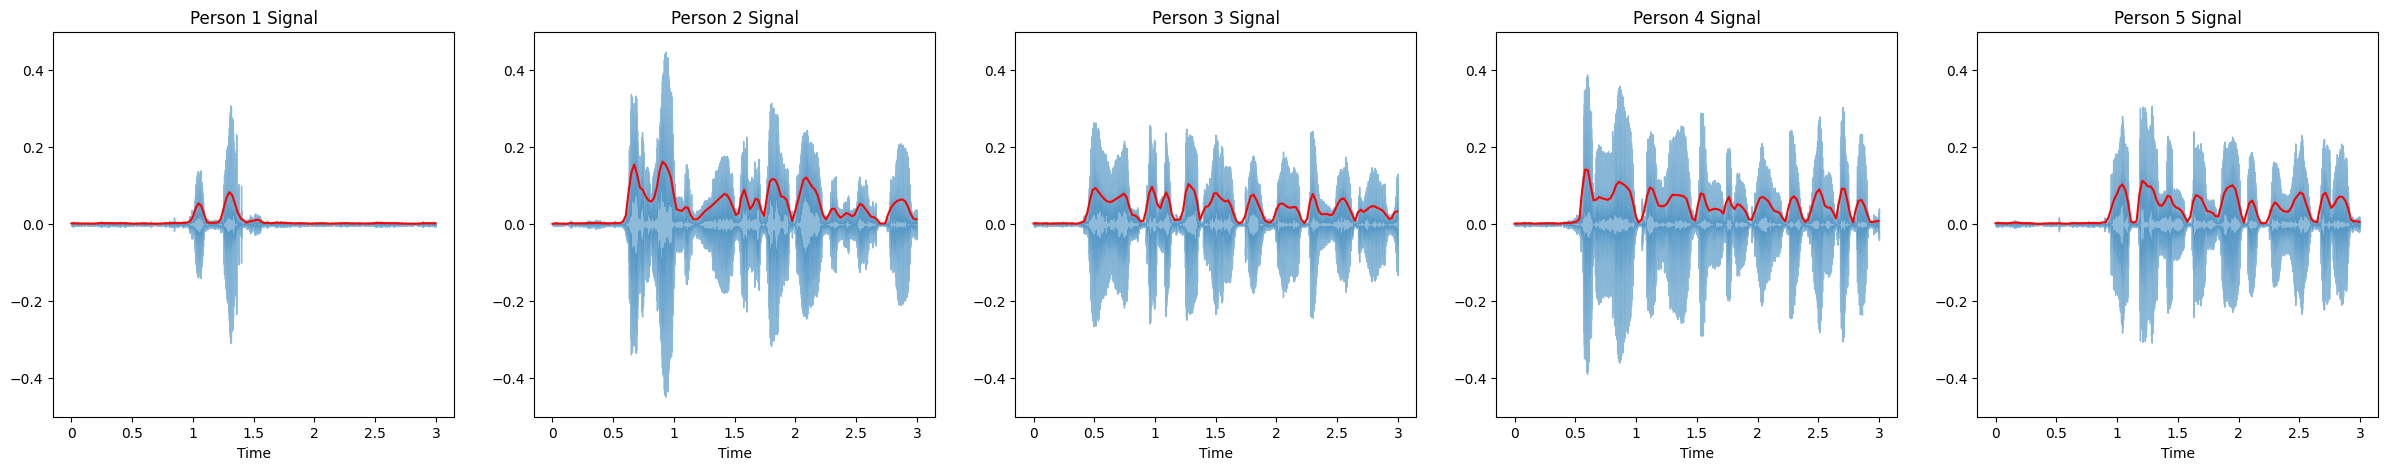

In [ ]:
plt.figure(figsize = (30,5))
plt.subplot(1,5,1)
librosa.display.waveshow(person1, alpha = 0.5)
plt.plot(t, rms_person1, color="r")
plt.title("Person 1 Signal")
plt.ylim((-0.5,0.5))

plt.subplot(1,5,2)
librosa.display.waveshow(person2, alpha = 0.5)
plt.plot(t, rms_person2, color="r")
plt.title("Person 2 Signal")
plt.ylim((-0.5,0.5))

plt.subplot(1,5,3)
librosa.display.waveshow(person3, alpha = 0.5)
plt.plot(t, rms_person3, color="r")
plt.title("Person 3 Signal")
plt.ylim((-0.5,0.5))

plt.subplot(1,5,4)
librosa.display.waveshow(person4, alpha = 0.5)
plt.plot(t, rms_person4, color="r")
plt.title("Person 4 Signal")
plt.ylim((-0.5,0.5))

plt.subplot(1,5,5)
librosa.display.waveshow(person5, alpha = 0.5)
plt.plot(t, rms_person5, color="r")
plt.title("Person 5 Signal")
plt.ylim((-0.5,0.5))

plt.show()

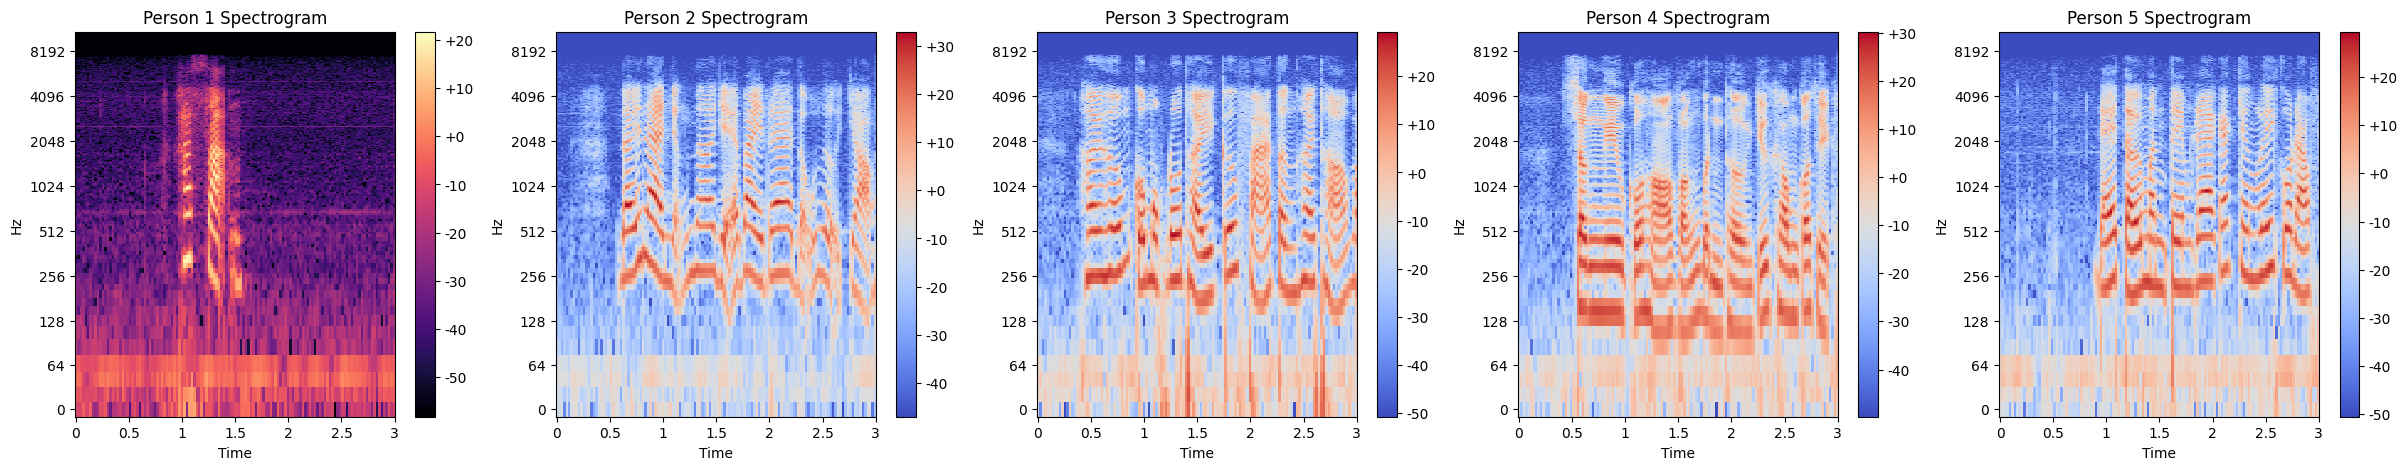

In [ ]:
plt.figure(figsize = (30,5))
plt.subplot(1,5,1)
plot_spectrogram(Y_person1, sr, HOP_LENGTH, y_axis= "log")
plt.title("Person 1 Spectrogram")

plt.subplot(1,5,2)
plot_spectrogram(Y_person2, sr, HOP_LENGTH, y_axis= "log")
plt.title("Person 2 Spectrogram")

plt.subplot(1,5,3)
plot_spectrogram(Y_person3, sr, HOP_LENGTH, y_axis= "log")
plt.title("Person 3 Spectrogram")

plt.subplot(1,5,4)
plot_spectrogram(Y_person4, sr, HOP_LENGTH, y_axis= "log")
plt.title("Person 4 Spectrogram")

plt.subplot(1,5,5)
plot_spectrogram(Y_person5, sr, HOP_LENGTH, y_axis= "log")
plt.title("Person 5 Spectrogram")

plt.show()

In [ ]:

# plot spectrum
plt.figure(figsize=(30,5))
plt.plot(frequency_person1, magnitude_person1)
plt.xlabel("frequency (Hz)")
plt.ylabel("magnitude")
plt.show()

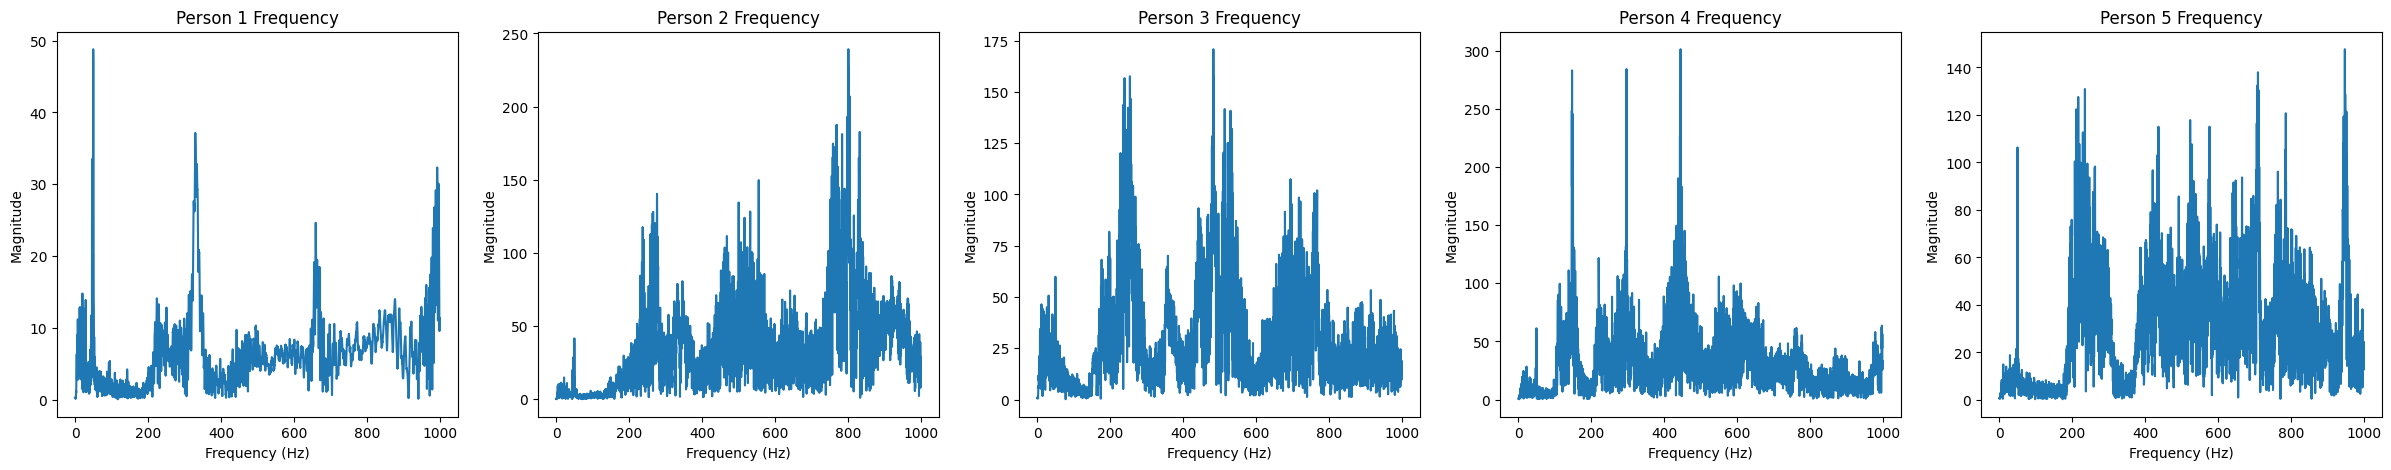

In [ ]:
# derive spectrum using FT
ft_person1 = sp.fft.fft(person1)
magnitude_person1 = np.absolute(ft_person1)
frequency_person1 = np.linspace(0, sr, len(magnitude_person1))

ft_person2 = sp.fft.fft(person2)
magnitude_person2 = np.absolute(ft_person2)
frequency_person2 = np.linspace(0, sr, len(magnitude_person2))

ft_person3 = sp.fft.fft(person3)
magnitude_person3 = np.absolute(ft_person3)
frequency_person3 = np.linspace(0, sr, len(magnitude_person3))

ft_person4 = sp.fft.fft(person4)
magnitude_person4 = np.absolute(ft_person4)
frequency_person4 = np.linspace(0, sr, len(magnitude_person4))

ft_person5 = sp.fft.fft(person5)
magnitude_person5 = np.absolute(ft_person5)
frequency_person5 = np.linspace(0, sr, len(magnitude_person5))


# plot spectrum
plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(frequency_person1[:3000], magnitude_person1[:3000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Person 1 Frequency")

plt.subplot(1,5,2)
plt.plot(frequency_person2[:3000], magnitude_person2[:3000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Person 2 Frequency")


plt.subplot(1,5,3)
plt.plot(frequency_person3[:3000], magnitude_person3[:3000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Person 3 Frequency")

plt.subplot(1,5,4)
plt.plot(frequency_person4[:3000], magnitude_person4[:3000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Person 4 Frequency")

plt.subplot(1,5,5)
plt.plot(frequency_person5[:3000], magnitude_person5[:3000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Person 5 Frequency")

plt.show()